<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=15% ALIGN="right">
</figure>

<center> <h1> <font color=00A6D6> CEGM2008 Case Study </font> </h1> </center>
<!--  color 00A6D6 is TU Delft colour -->
<center> <h1> <font color=00A6D6> Evaluating Uncertainty in Earthquake-Location Estimates for Groningen Seismicity  </font> </h1> </center>

<center> <h3>  Michaël van Rijnsoever - 4853830</h3> </center>
<center> <h3>  Jasper Spijkerboer - 5089409  </h3> </center>
<center> <h3>  Gijs van Grieken - 5168961 </h3> </center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

This Notebook presents the answers to the Case-Study of Groningen's seismicity evaluation.

## General

In this section, somegeneral useful parameters are calculated that could be useful for later assignments.

In [2]:
#define the time sampling and total recording time of seismic data
dt = 0.002  # s
tmax = 7.9  # s
nt = int(tmax/dt) + 1   # IMPORTANT: inclusive end time -> 3951
t = np.arange(nt)*dt

#sampling frequency
f_s = 1 / dt
f_n = f_s / 2

#defines the positions of the receviers
dx_rec = 2.5
x_rec = np.arange(2000.0, 8000.0 + dx_rec/2, dx_rec)
nx = x_rec.size
x_src = 5001.0

dz = 1.25  # log/model depth sampling

#centre freq
f_centre = 40 #Hz


## Task 1: load in the data and show the gathers



To load in the data, different fucntions are made. The first function reads all of the BIN files and reshapes them into a 2D array with dimenions of: time samples x recevier positions. A check is included to make sure the geometry is on order.

The second function reads the 1D files, such as the time samples or the receiver positions separately. A check is also included in this function to make sure the seismic data and the coordinates match.

The third function visualizes the different gathers. Amplitude clipping is applied based on a percentile. This should make sure that signals with high amplitudes are clipped and that all the important data is thus clearly visible.

In [3]:
#function to read the binary file
def read_gather(path, nt=nt, nx=nx, dtype=np.float32):
    tmp = np.fromfile(path, dtype=dtype)
    if tmp.size != nt*nx:
        raise ValueError(f"{path}: expected {nt*nx}, got {tmp.size}")
    # IMPORTANT: data is trace-major → Fortran order
    return np.reshape(tmp, (nt, nx), order='F')


def read_1d(path, n, dtype=np.float32):
    a = np.fromfile(path, dtype=dtype)
    if a.size != n:
        raise ValueError(f"{path}: expected {n}, got {a.size}")
    return a

#shows a seismic gather as an image, time vertically and recevier point horizontally
def show_gather(g, title, clip=99.5):
    # Amplitude clipping for display
    lim = np.percentile(np.abs(g), clip)

    # Define physical axes
    extent = [
        np.min(x_rec),           # receiverPositions min
        np.max(x_rec),           # receiverPositions max
        np.max(t),               # timeSamples max (bottom)
        np.min(t)                # timeSamples min (top)
    ]

    plt.figure(figsize=(10,5))
    plt.imshow(
        g,
        cmap="gray",
        aspect="auto",
        extent=extent,
        vmin=-lim,
        vmax=lim
    )
    plt.xlabel("Receiver position (m)")
    plt.ylabel("Time (s)")
    plt.title(title)
    plt.show()


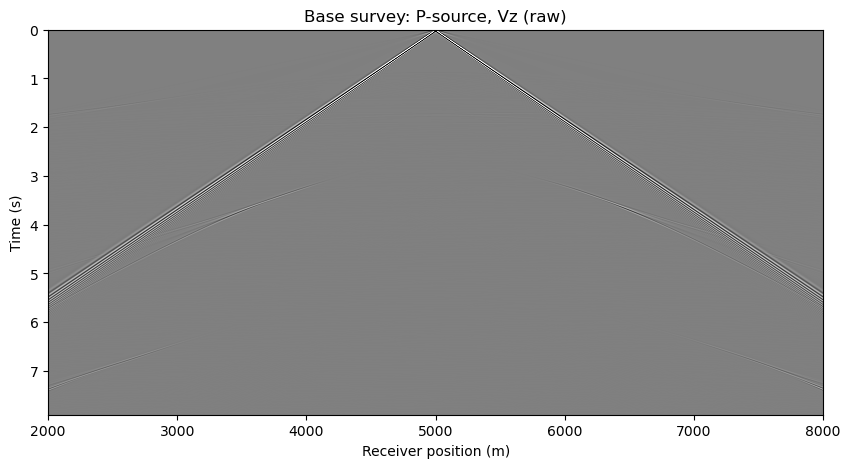

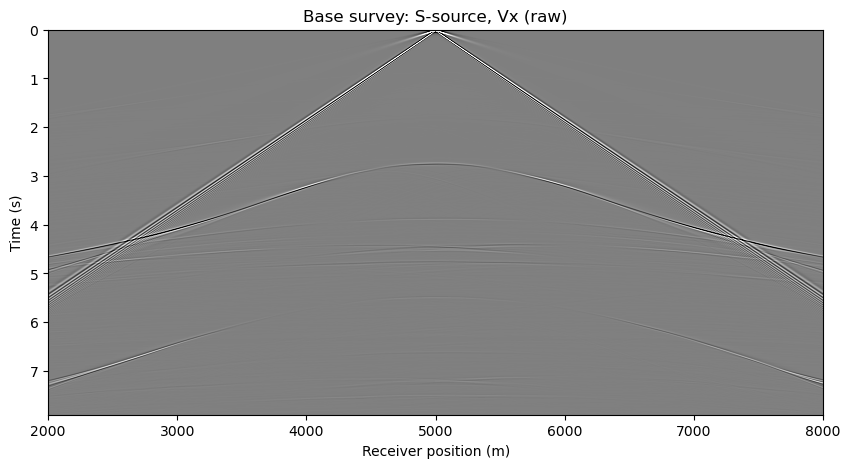

In [4]:
gP_base = read_gather("shot_base_p_source_at_5001_and_rvz.bin")
gS_base = read_gather("shot_base_s_source_at_5001_and_rvx.bin")
gP_mon  = read_gather("shot_monitor_p_source_at_5001_and_rvz.bin")
gS_mon  = read_gather("shot_monitor_s_source_at_5001_and_rvx.bin")

vp_log = read_1d("borehole_Pwave_log.bin", n=3600)
vs_log = read_1d("borehole_Swave_log.bin", n=3600)


#these are the two graphs also seen in the assignment, so the data is correctly imported and reshaped
show_gather(gP_base, "Base survey: P-source, Vz (raw)")
show_gather(gS_base, "Base survey: S-source, Vx (raw)")


In these pictures you can see clear resemblance to the ones in the assignment. The important thing to do here is to reshape the data so that it is displayed correctly. P-waves are more horizontal flat lines, as they travel very fast. S-waves look more like a bell shape with flat outer ends, as they first travel quickly and then slow down.

## Task 2: supression of the surface waves

In this question, you are asked to suppress waves. This is done with the use of filters.

To determine the maximum frequency that we want to preserve, the centre frequency is used. For a typical seismic source (Ricker wavelet), most of the energy is concentrated around the centre frequency. A ricker Wavelet with centre frequency $f_0$ has strong spectral content from 0 to 3 * $f_0$. With $f_0$ = 40 Hz, the $f_{max}$ = 120 Hz. Since this is well below the Nyquist frequency, no aliasing should occur.

The filter is applied in the f-k domain, because different wave types separate by apparent velocity in that domain. In the f-x domain, the different wave types do not separate cleanly. This would result in either failure of applying the filter the removal of useful data.

There are two important wave types that we want to distinguish:
- Surface waves: are slow and have a different apparant velocity. Surface waves have a low apparant velocity.
- Reflection waves: are faster and have a hyperbolic shape. Reflection waves have a high apparant velocity.

The waves are separated based on their difference in apparant velocity in the f-k domain, which can be seen as a clear separation of energy in the f-k domain. 

Based on the base surveys, the velocity of the surfacewaves is computed by using: V = S/ (TWT/2). This results in a velocity of approximately 1200 m/s for the P-waves and 1100 m/s for the S-waves.

The filter which is applied is linear. A linear filter is preferred as it allows for smooth transitions, making sure no abrubt cut-off happens which could result in ringing in the space-time domain. 

What the function in the following cell does:
1) Transform the gather from (t, x) to (f, k) using a 2D FFT.
2) Compute an apparent-velocity field v_app = |omega| / |k| across the f–k grid.
3) Build a smooth mask that preserves energy with apparent velocity >= vmin (and |f| <= fmax),
       tapering across a small transition band to avoid ringing.
4) Apply the mask in f–k space and transform back to (t, x) with an inverse 2D FFT.

In [5]:
def fk_filter(
    reflectionData,
    dt,
    dx,
    vmin,
    fmax=120.0,
    taper=0.15,
    plot_fk=True,
    plot_mask=True
):
    """
    reflectionData : Seismic gather in time-space domain (nt, nx) 
    dt: Time sampling (s).
    dx: Receiver spacing (m).
    vmin: Minimum apparent velocity to preserve (m/s).
    fmax: Maximum frequency to preserve (Hz).
    taper: Relative width of the taper around vmin.
    plot_fk: Plot magnitude of the f-k spectrum.
    plot_mask: Plot the f-k mask.
    """


    # Step 1: FFT to f-k domain
    nt, nx = reflectionData.shape

    FK = np.fft.fft2(reflectionData)
    FKsh = np.fft.fftshift(FK)

    f = np.fft.fftshift(np.fft.fftfreq(nt, d=dt))   # Hz
    k = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))   # cycles/m


    # Step 2: Apparent velocity calculation
    w = 2*np.pi*f[:, None]         # rad/s
    kr = 2*np.pi*k[None, :]        # rad/m

    eps = 1e-12
    vapp = np.abs(w) / (np.abs(kr) + eps)


    # Step 3: Build the mask
    bandMask = (np.abs(f) <= fmax)[:, None]

    #Ramp the filter (linearly in this case) in order to avoid a sharp cut-off
    v0 = vmin*(1 - taper)
    v1 = vmin*(1 + taper)

    ramp = np.clip((vapp - v0) / (v1 - v0 + eps), 0, 1)

    mask = ramp * bandMask


    # Step 4: Plot f-k spectrum (optional)
    if plot_fk:
        extent_fk = [k[0], k[-1], f[-1], f[0]]

        plt.figure(figsize=(14,6))
        plt.imshow(
            np.log10(np.abs(FKsh) + 1e-12),
            aspect="auto",
            extent=extent_fk
        )
        plt.title("Common-source gather in f–k domain (log amplitude)")
        plt.xlabel("Wavenumber k (cycles/m)")
        plt.ylabel("Frequency f (Hz)")
        plt.colorbar(label="log10 |G(f,k)|")
        plt.show()


    # Step 5: Plot the mask (optional)
    if plot_mask:
        extent_mask = [k[0], k[-1], f[-1], f[0]]

        plt.figure(figsize=(14,6))
        plt.imshow(
            mask,
            aspect="auto",
            extent=extent_mask,
            vmin=0,
            vmax=1
        )
        plt.title("f–k mask (0 = removed, 1 = preserved)")
        plt.xlabel("Wavenumber k (cycles/m)")
        plt.ylabel("Frequency f (Hz)")
        plt.colorbar(label="Mask value")
        plt.show()

    # Step 6: Apply mask and inverse FFT
    FKf = FKsh * mask
    FKf = np.fft.ifftshift(FKf)

    filteredData = np.real(np.fft.ifft2(FKf))

    return filteredData, mask, f, k


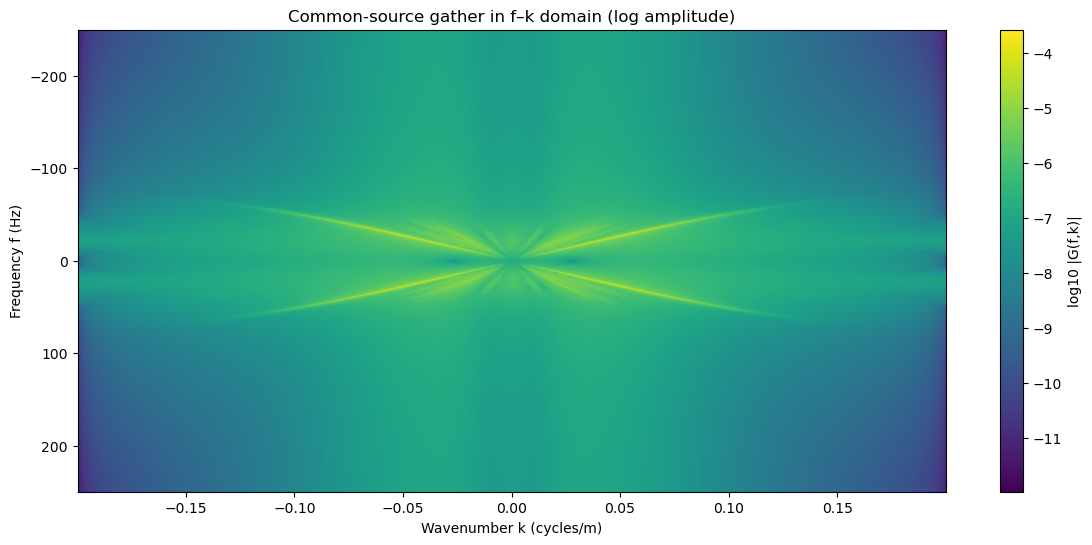

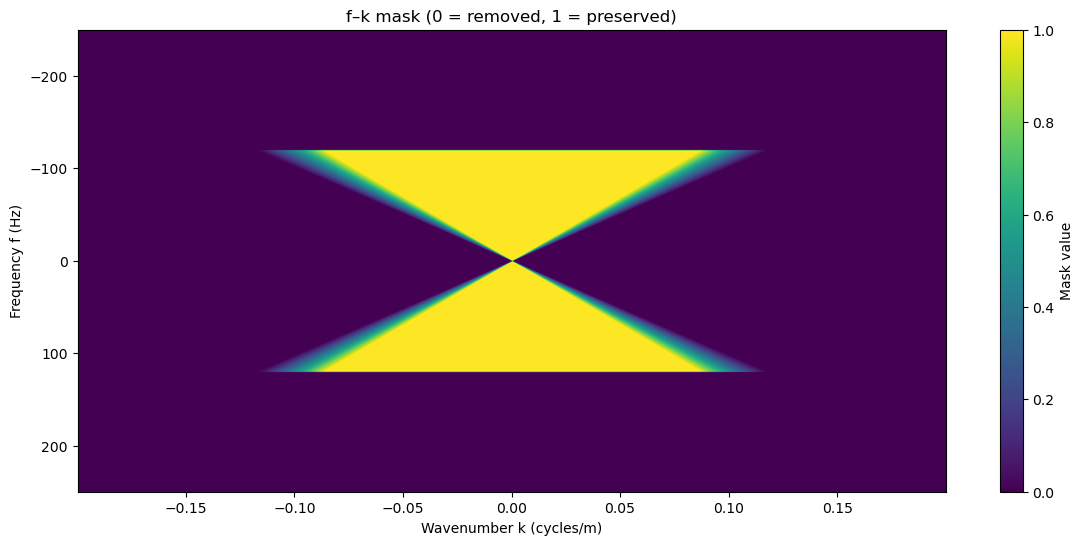

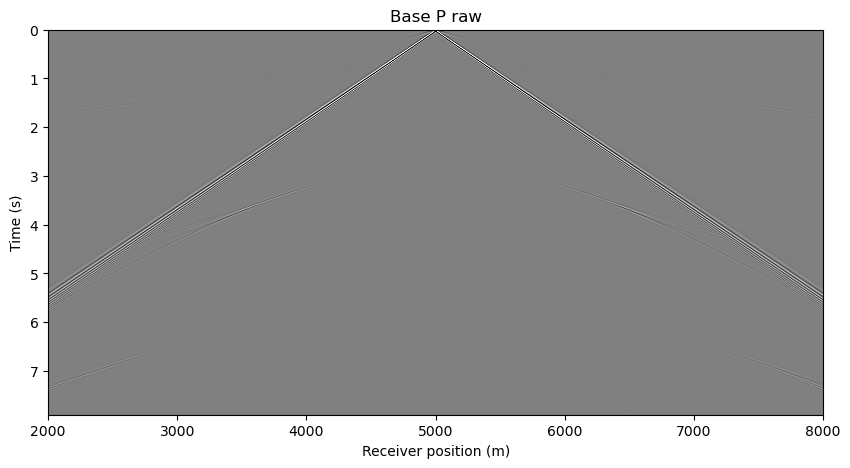

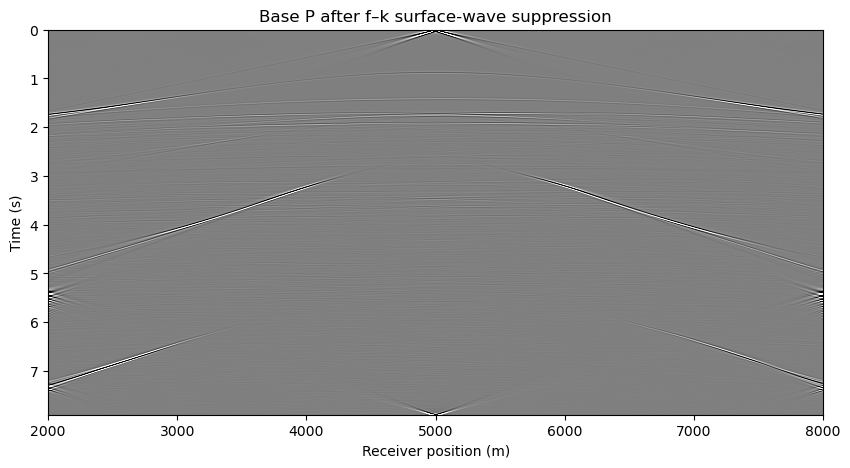

In [6]:
#suppression of the p-waves
gP_base_f, maskP, fP, kP = fk_filter(
    gP_base,
    dt,
    dx_rec,
    vmin=1200,
    fmax=120,
    plot_fk=True,
    plot_mask=True
)

show_gather(gP_base,   "Base P raw")
show_gather(gP_base_f, "Base P after f–k surface-wave suppression")


There is a clear visual distiction between the base-P and the supressed base-P. The supression has thus allowed us to remove any unwanted energy in the f-k domain, without causing disruption in the space-time domain.

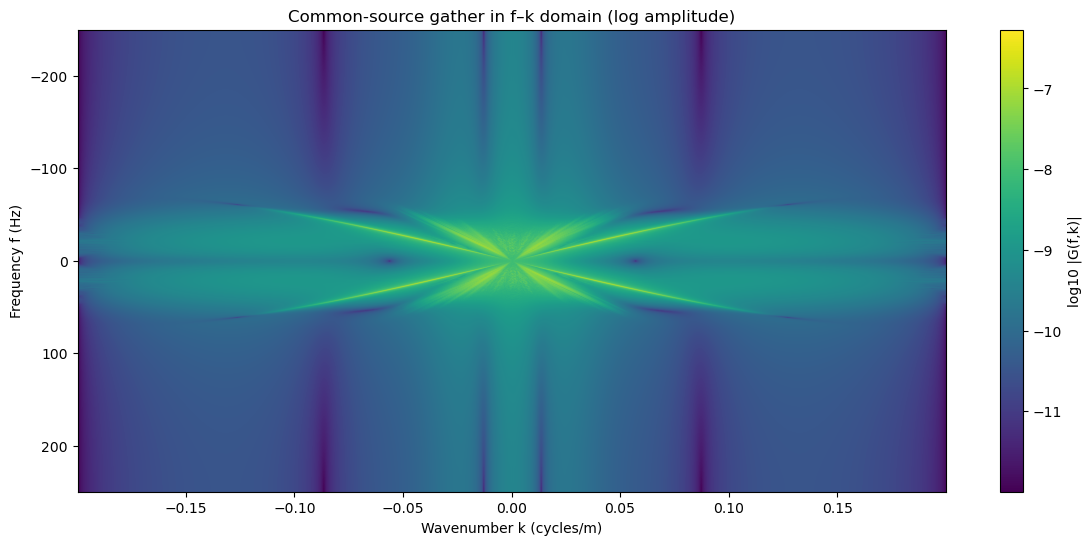

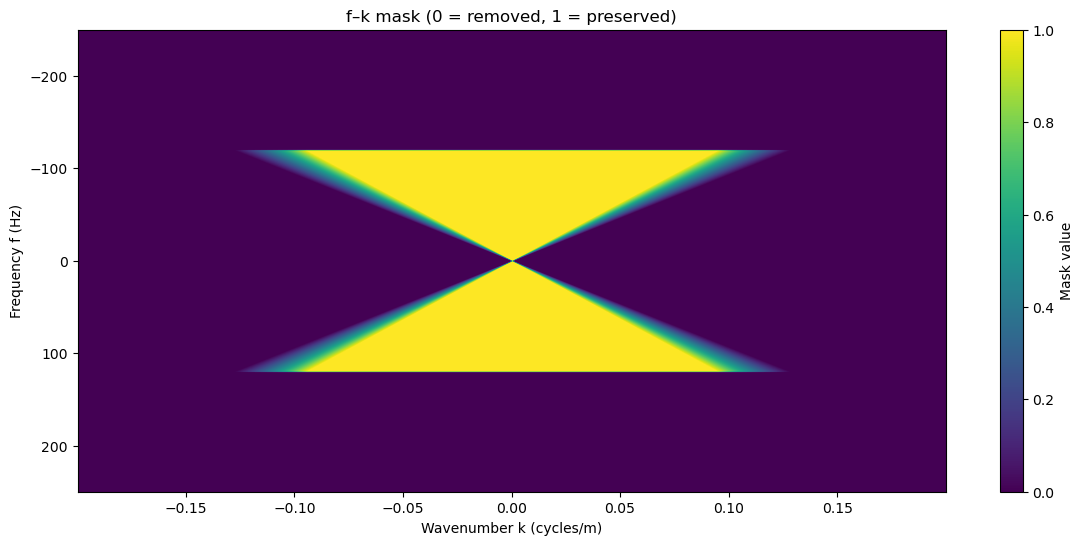

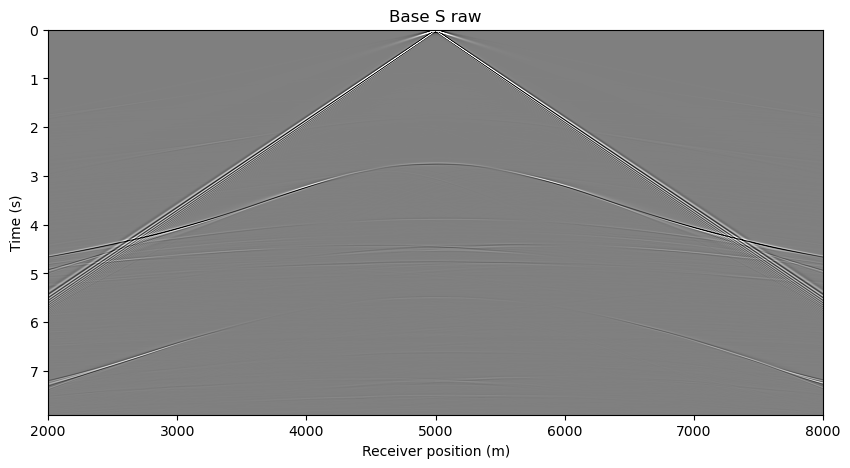

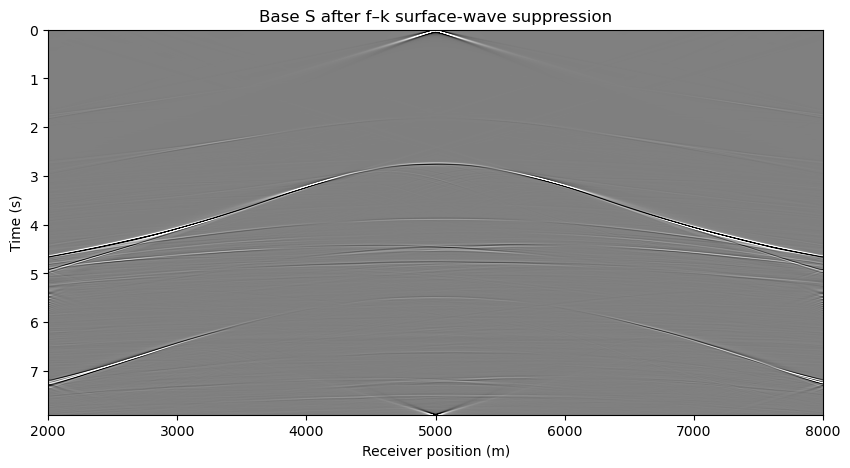

In [7]:
#supression of the s-waves
gS_base_f, maskS, fS, kS = fk_filter(
    gS_base,
    dt,
    dx_rec,
    vmin=1100,
    fmax=120,
    plot_fk=True,
    plot_mask=True
)

show_gather(gS_base,   "Base S raw")
show_gather(gS_base_f, "Base S after f–k surface-wave suppression")



There is a clear visual distiction between the base-S and the supressed base-S. The supression has thus allowed us to remove any unwanted energy in the f-k domain, without causing disruption in the space-time domain.

In conclusion, linear f–k filtering effectively suppresses surface-wave energy while preserving reflection signals, leading to improved event continuity and the appearance of more clearly identifiable reflection lines in the gather.

## Task 3: analysing the common-source gathers and show the reflections

In this section, the common-sorce gathers are analysed and reflections are visualised on the given veloity-profiles. The following method is applied in the code:
1. Convert velocity log to travel time: for each depth sample, compute the one-way time increment:
   $$\Delta t_{\text{ow}} = \Delta z / v(z)$$ and cumulative-sum it to get: $$t_{\text{ow}}(z)$$ Two-way travel time is then: $$t_{\text{TWT}}(z)=2,t_{\text{ow}}(z)$$

2. Compute RMS velocity: accumulate: $$v^2\Delta t$$ and divide by: $$\Delta t$$ to obtain:
   $$
   v_{\text{rms}}(t)=\sqrt{\frac{\int v^2 dt}{\int dt}}
   $$ 
   This is the effective velocity that controls reflection moveout in layered media. 

3. Predict reflection moveout as a hyperbola: for a reflector with zero-offset time $$t_0$$ compute arrival times at each receiver using
$$t(x)=\sqrt{t_0^2+(x/v_{\text{rms}})^2}$$ where $$x=|x_{\text{rec}}-x_{\text{src}}|$$

4. Overlay and label reflections: take $$t_0$$ from the TWT curve at the reflector depth and use $$v_{\text{rms}}(t_0)$$ to plot the predicted hyperbola on the gather. If it aligns with a coherent event, that event is labelled as the reflection from that depth/interface.



To assess whether the identified interfaces in the velocity model can be resolved in the seismic data, the vertical resolution is estimated using the quarter-wavelength criterion. The vertical resolution in seismics is approximated by:

$$
\Delta z \approx \frac{\lambda}{4} = \frac{v}{4f}
$$

where the wavelength is given by
$$
\lambda = \frac{v}{f}.
$$

Abrupt changes or jumps in the velocity profile occur at the following depths:

General:
- f = 40 Hz, which is the centre frequency

P-wave velocity profile:
- 800 m, with v = 2500 m/s
- 1700 m, with v = 4500 m/s
- 1900 m, with v = 4400 m/s
- 2200 m, with v = 6000 m/s
- 2900 m , with v = 6000 m/s

S-wave velocity profile: 
- 800 m, with v = 1200 m/s
- 1700 m, with v = 2400 m/s
- 1900 m, with v = 2500 m/s
- 2200 m, with v = 3500 m/s
- 2900 m, with v = 3500 m/s

Calculation of the required vertical resolution:
- The maximum speed of P-waves is determined at 6000 m/s
- The maximum speed of S-waves is determined at 3500 m/s

As velocity varies with depth, the vertical resolution is depth dependent. However, using the maximum velocity in the model provides a conservative upper bound on the minimum resolvable layer thickness. Interfaces separated by more than this bound are therefore resolvable.

This means that the vertical resolution for P-waves, based on the maximum velocity, is:
$$
\Delta z_p \approx \frac{\lambda}{4} = \frac{v}{4f} = \frac{6000}{4 * 40} = 37.5 m
$$
And for S-waves:
$$
\Delta z_s \approx \frac{\lambda}{4} = \frac{v}{4f} = \frac{3500}{4 * 40} = 21.875 m
$$

At high P-wave velocities (up to 6000 m/s), the wavelength at the centre frequency
of 40 Hz becomes large (λ ≈ 150 m), resulting in a vertical resolution of
approximately 37.5 m. This limits the ability to resolve thin layers or closely
spaced interfaces using P-wave data.


In [8]:
# function to compute two way travel time and RMS velocity
def twt_vrms(v, dz=1.25):
    dt_ow = dz / v #delta_z/v
    t_ow  = np.cumsum(dt_ow) #one-way travel time
    twt   = 2 * t_ow #two-way travel time
    vrms  = np.sqrt(np.cumsum((v**2) * dt_ow) / (np.cumsum(dt_ow) + 1e-12)) #compute the RMS velocity
    return twt, vrms

#Reflection hyperbola -
def hyperbola(t0, vrms, x_rec, x_src):
    off = np.abs(x_rec - x_src)
    return np.sqrt(t0**2 + (off/vrms)**2) #Predicts how a reflection wave looks in a common-source gather

twtP, vrmsP = twt_vrms(vp_log)
twtS, vrmsS = twt_vrms(vs_log)

def twt_from_vp_log(vp_log, dz=1.25):
    """ 
    vp_log: P-wave velocity as function of depth (m/s)
    dz: Depth sampling (m)

    """
    z = np.arange(len(vp_log)) * dz
    t1w = np.cumsum(dz / vp_log)
    t1w = np.insert(t1w[:-1], 0, 0.0)   # t=0 at surface
    twt = 2.0 * t1w
    return z, t1w, twt

twt_old, _ = twt_vrms(vp_log)
z, tw1, twt_new = twt_from_vp_log(vp_log)

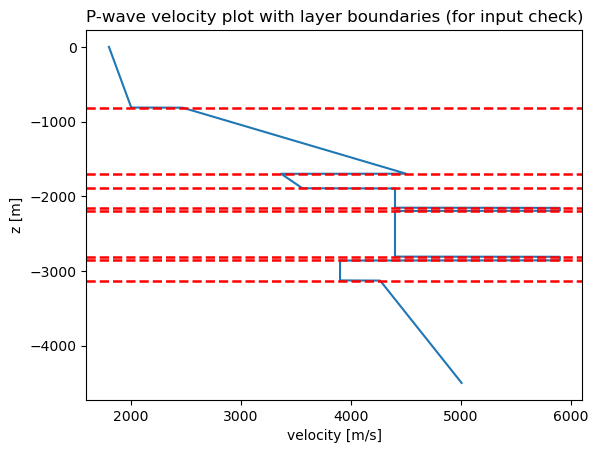

In [14]:
# function to find velocity jumps
def find_velocity_jumps(v, dz, dv_threshold):
    """
    Find indices where dv exceeds a threshold.
    """
    dv = np.abs(np.diff(v))
    idx = np.where(dv > dv_threshold)[0] + 1
    depths = idx * dz
    return idx, depths

# Detect all velocity jumps (P-wave example)
idxP, depthsP = find_velocity_jumps(vp_log, dz, dv_threshold=100)

#Plot to check if velocity jumps are correct
plt.plot(vp_log, -z)
plt.ylabel("z [m]")
plt.xlabel("velocity [m/s]")
plt.title("P-wave velocity plot with layer boundaries (for input check)")
for i in range(len(depthsP)):
    plt.axhline(-depthsP[i], color='red', lw=1.8, linestyle='--')

All major velocity contrasts from the borehole logs were initially used to
predict reflection arrival times and overlaid on the common-source gathers.
However, due to the vertical resolution limit (Δz ≈ λ/4), not all interfaces
can be expected to generate separate, observable reflections. In particular,
for P-waves at high velocities (v ≈ 6000 m/s), the vertical resolution is
approximately 37.5 m. Consequently, only interfaces that produce clear,
continuous reflection events in the seismic data were retained for final
labelling. This means that each peak was kept, as they all fit within the vertical resolution of the reflected P-waves, which is the critical vertical resolution.


Waves that are flatter, more horizontal line like, travel faster, thus they will be P-waves. Waves that are first parabolic and then flatten when going away from the receiver position, are S-waves.

A key takeaway is that: you may predict many reflectors from the velocity log, but the seismic data decides which ones are actually visible — and vertical resolution explains why.

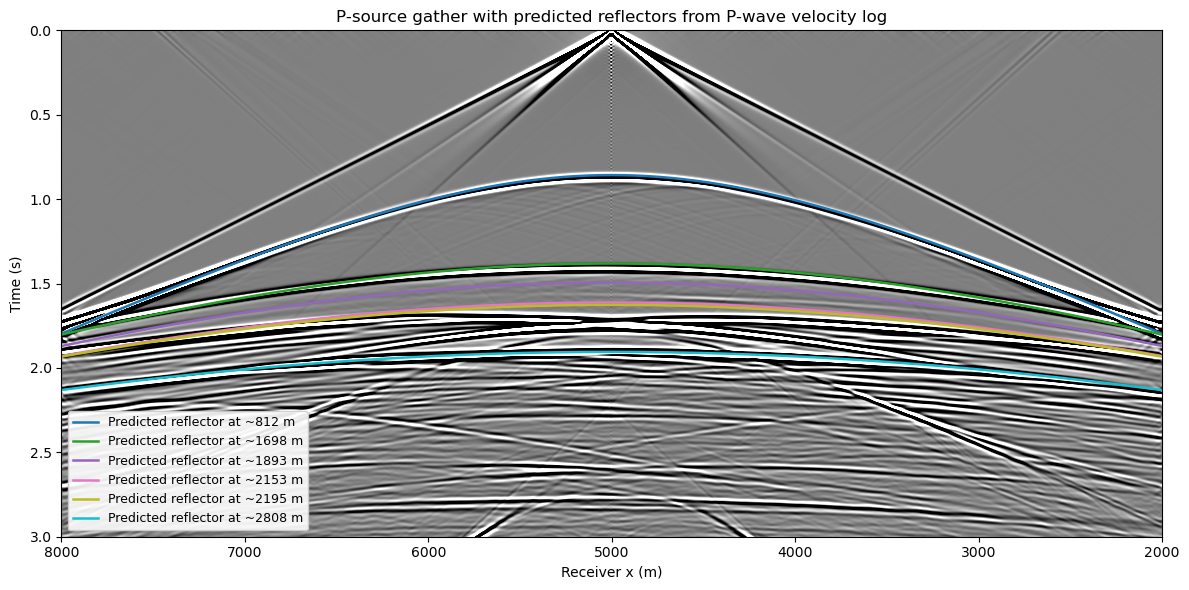

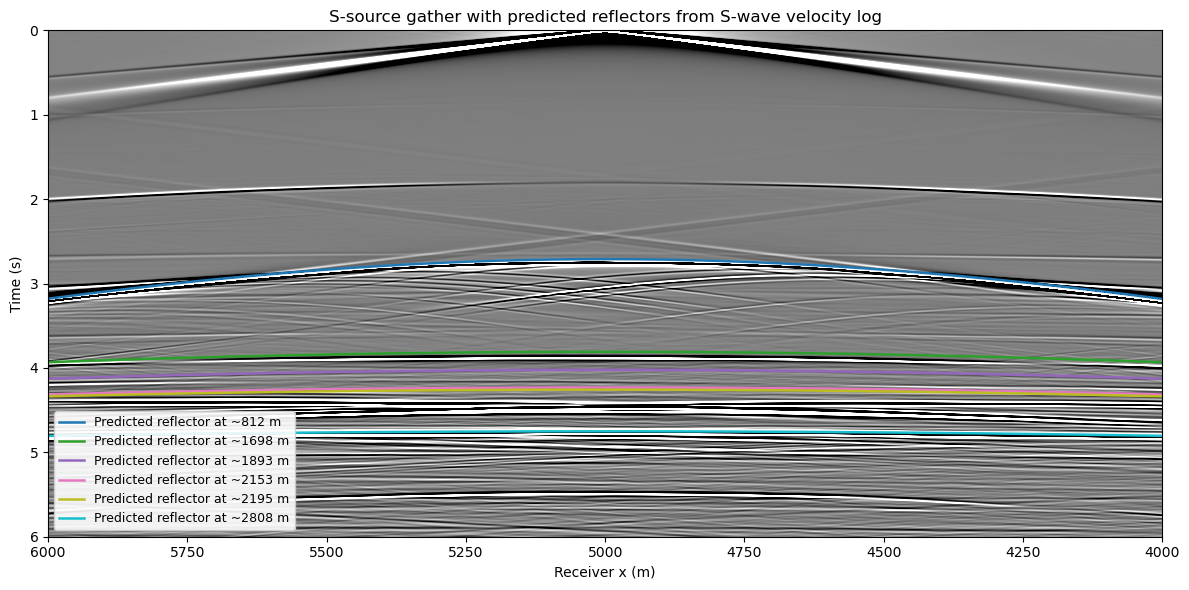

In [24]:
def plot_reflections(
    g, twt, vrms, idx, depths, title, y_lim, x_lim, clip
):
    """
    Plot a seismic gather with predicted reflector times overlaid.

    g: Seismic gather in the time–space domain with shape (nt, nx).
    twt: Two-way travel time as a function of depth (s).
    vrms: RMS velocity as a function of travel time (m/s), used to predict moveout.
    idx: Indices of velocity-log samples where abrupt velocity changes occur.
    depths: Depths corresponding to the velocity jumps (m).
    title: Title of the figure.
    y_lim: Time-axis limits (s) for display.
    x_lim: Receiver-position limits (m) for display.
    clip: Percentile for amplitude clipping to enhance visibility of reflections.
    """
    lim = np.percentile(np.abs(g), clip)
    extent = [np.min(x_rec), np.max(x_rec), np.max(t), np.min(t)]

    plt.figure(figsize=(12,6))
    plt.imshow(
        g,
        cmap="gray",
        aspect="auto",
        extent=extent,
        vmin=-lim,
        vmax=lim
    )
    plt.xlabel("Receiver x (m)")
    plt.ylabel("Time (s)")
    plt.title(title)

    # Create a color map for unique reflector colours
    colors = cm.tab10(np.linspace(0, 1, len(depths)))

    lines = []
    labels = []

    for i, d, c in zip(idx, depths, colors):
        curve = hyperbola(twt[i], vrms[i], x_rec, x_src)
        line, = plt.plot(x_rec, curve, color=c, lw=1.8)
        lines.append(line)
        labels.append(f"Predicted reflector at ~{int(d)} m")

    plt.ylim(y_lim[1], y_lim[0])
    plt.xlim(x_lim[1], x_lim[0])

    # Add legend
    plt.legend(
        lines,
        labels,
        loc="lower left",
        fontsize=9,
        framealpha=0.9
    )

    plt.tight_layout()
    plt.show()

# P-wave candidates
idxP, depthsP = find_velocity_jumps(vp_log, dz, dv_threshold=300)

plot_reflections(
    gP_base_f,
    twtP,
    vrmsP,
    idxP[0:6],
    depthsP[0:6],
    "P-source gather with predicted reflectors from P-wave velocity log",
    y_lim=[0, 3],
    x_lim = [2000, 8000],
    clip = 90
)

# S-wave candidates
idxS, depthsS = find_velocity_jumps(vs_log, dz, dv_threshold=200)

plot_reflections(
    gS_base_f,
    twtS,
    vrmsS,
    idxS[0:6],
    depthsS[0:6],
    "S-source gather with predicted reflectors from S-wave velocity log",
    y_lim = [0, 6], 
    x_lim = [4000, 6000],
    clip = 90
)


It can be seen in these plots that the reflections from the S-waves arrive much later than P-wave refelections, which is logical because P-waves travel faster than S-waves.  
<br>
Furthermore, for both the P and S waves, most of the predicted reflectors can be distinguished in the source-gather plots, expect for the 3rd predicted reflector at +- 1893, at the boundary between the 3rd and 4th layer. Further adjustment of the clipping doesn't help. The reason for this is not known, it might be due to a low impedance contrast at this interface.

## Task 4: Detecting velocity changes

Using the common-source gathers from the base and monitor surveys, the presence of velocity changes is analysed by directly comparing the two surveys. Because changes in subsurface velocity affect travel times and reflection moveout, differences between the base and monitor gathers can be used to detect whether velocity changes occurred. In the analysis it is assumed that any velocity change is confined to a single layer.

In the code, the following is done:
1. Form a difference gather between the monitored and base survey.
2. Visualize time shifts
3. Identify reflector dephts from velocity logs.
4. Overlay predicted reflector times
5. Infer the layer with velocity change
6. Apply to P- and S-wave data

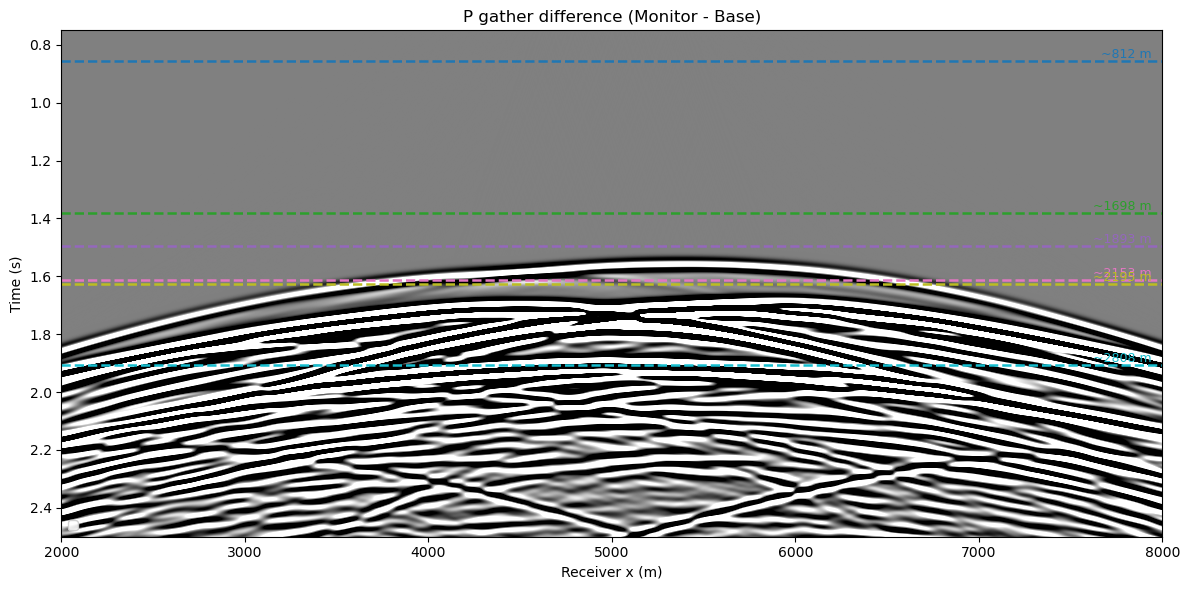

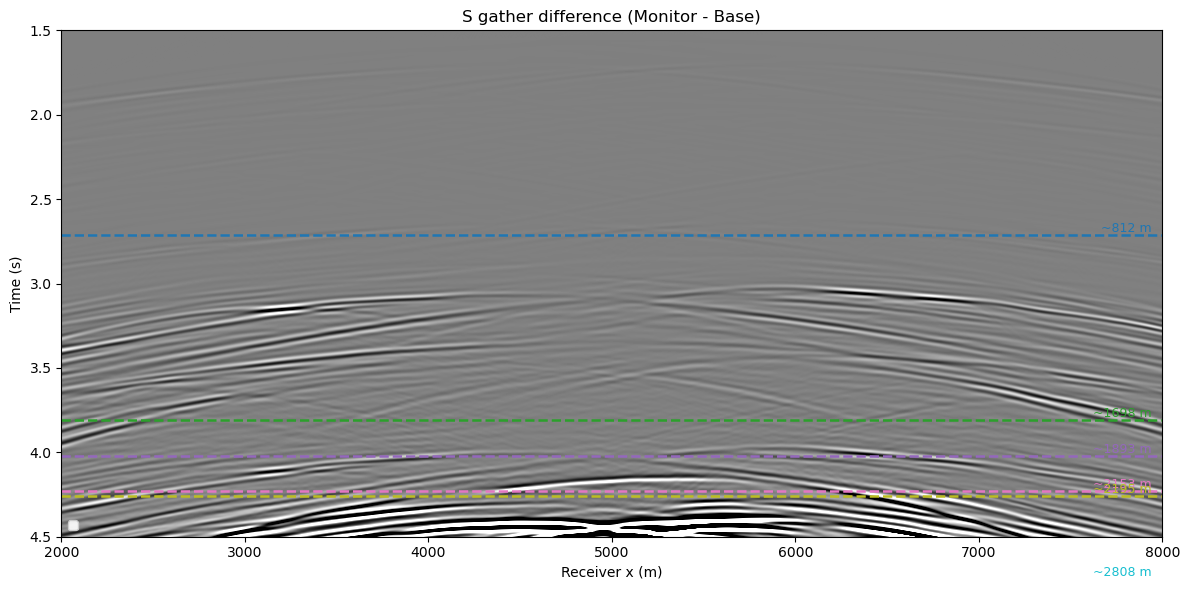

In [27]:
def difference_gather(base, mon, title, idx, depths, twt, vrms, y_lim, clip=80):
    """
    Compute and display a difference gather (monitor − base).

    base: Base-survey seismic gather in the time–space domain (nt, nx).
    mon: Monitor-survey seismic gather in the time–space domain (nt, nx).
    title: Title of the figure.
    idx: Indices of velocity-log samples corresponding to candidate reflector depths.
    depths: Depths of the candidate reflectors (m).
    twt: Two-way travel time as a function of depth (s).
    vrms: RMS velocity as a function of travel time (m/s).
    y_lim: Time-axis limits (s) for display.
    clip: Percentile for amplitude clipping of the difference gather.
    """

    """Plot delta = monitor - base."""
    dg = mon - base
    lim = np.percentile(np.abs(dg), clip)
    extent = [np.min(x_rec), np.max(x_rec), np.max(t), np.min(t)]
    plt.figure(figsize=(12,6))
    plt.imshow(dg, cmap="gray", aspect="auto", extent=extent, vmin=-lim, vmax=lim)

    colors = cm.tab10(np.linspace(0, 1, len(depths)))

    lines = []
    labels = []

    for i, d, c in zip(idx, depths, colors):
        plt.axhline(twt[i], color=c, lw=1.8, linestyle='--')
        #lines.append(line)
        plt.text(
            0.99, twt[i],
            f"~{int(d)} m",
            color=c,
            fontsize=9,
            va='bottom',
            ha='right',
            transform=plt.gca().get_yaxis_transform()
        )
        labels.append(f"Predicted reflector at ~{int(d)} m")

    plt.xlabel("Receiver x (m)")
    plt.ylabel("Time (s)")
    plt.ylim(y_lim[1], y_lim[0])
    plt.title(title + " (Monitor - Base)")
    plt.legend(
        lines,
        labels,
        loc="lower left",
        fontsize=9,
        framealpha=0.9
    )
    plt.tight_layout()
    plt.show()
    return dg

P_base = gP_base
P_mon  = gP_mon
S_base = gS_base
S_mon  = gS_mon

idxP, depthsP = find_velocity_jumps(vp_log, dz, dv_threshold=300)
idxS, depthsS = find_velocity_jumps(vs_log, dz, dv_threshold=200)

# 2) Difference gathers
dP = difference_gather(P_base, P_mon, "P gather difference", idxP[0:6], depthsP[0:6], twtP, vrmsP, y_lim=[0.75,2.5], clip=70)
dS = difference_gather(S_base, S_mon, "S gather difference", idxS[0:6], depthsS[0:6], twtS, vrmsS, y_lim=[1.5,4.5], clip=95)

    


Velocity changes were detected between base and monitoring survey by calculating and plotting the difference between the base and common source gathers (unfiltered, as surface waves are the same for both they automatically fall away). To match the changes to the layers, we overlayed the layers on the graph showing differences, and scaled y-limit of the graph to the first observerd differences. After the first differences, we can observe visually that at what layer the this occurs. This can be best done using the P-wave difference plot. The P-wave difference plot shows a single clear event because the Vz data is dominated by coherent P-wave arrivals that largely cancel during subtraction, except where the velocity change affects travel times. The S-wave difference plot appears noisier because S-waves are slower and more sensitive to velocity changes, and the Vx component contains more complex wavefield energy that does not cancel perfectly. The clear difference in the P-wave difference plot is observed just below the 3rd line (at +- 1893 m), which corresponds with the 4th layer. This means that the velocity change is in the 4th layer.

# Task 5

To estimate the difference in velocity of the changed layer (layer 4), we will visually observe the difference in the base and monitor plots. The difference in two-way travel time, where a certain reflection is observed, will be used to estimate the velocity difference. This should ideally be the reflection at the bottom of the 4th layer, where all of the difference in two way travel time can be attributed to the change in velocity in the 4th layer. This is done below, first for the P-waves, and then for the S-waves.

In [30]:
def plot_base_monitor_side_by_side(
    g_base, g_mon, t, x_rec, t_pick,
    y_lim=(0.0, 3.0), x_lim=(2000, 8000),
    clip=95,
    cmap="gray",
    title_base="Base",
    title_mon="Monitor",
):
    """
    Plot base and monitor seismic gathers side by side for comparison.

    g_base: Base-survey seismic gather in the time–space domain (nt, nx).
    g_mon: Monitor-survey seismic gather in the time–space domain (nt, nx).
    t: Time samples corresponding to the vertical axis (s).
    x_rec: Receiver positions along the surface (m).
    t_pick: Picked reflection time(s) to be highlighted in the gathers (s).
    y_lim: Time-axis limits (s) for display.
    x_lim: Receiver-position limits (m) for display.
    clip: Percentile for amplitude clipping to enhance visibility.
    """
  
    # consistent amplitude scaling for fair comparison
    lim = max(np.percentile(np.abs(g_base), clip),
              np.percentile(np.abs(g_mon),  clip))

    extent = [np.min(x_rec), np.max(x_rec), np.max(t), np.min(t)]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # time/depth for chosen reflector
    for ax, g, ttl in zip(axes, [g_base, g_mon], [title_base, title_mon]):
        ax.imshow(g, cmap=cmap, aspect="auto", extent=extent, vmin=-lim, vmax=lim)
        ax.set_title(ttl)
        ax.set_xlabel("Receiver x (m)")
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[1], y_lim[0])  # invert y-axis

        # optional extra reference line
        for t in t_pick:
            ax.axhline(t, color="yellow", lw=1.5, linestyle="--")

    axes[0].set_ylabel("Time (s)")
    fig.suptitle("Base vs Monitor comparison", y=1.02, fontsize=14)

    plt.tight_layout()
    plt.show()


## P-waves

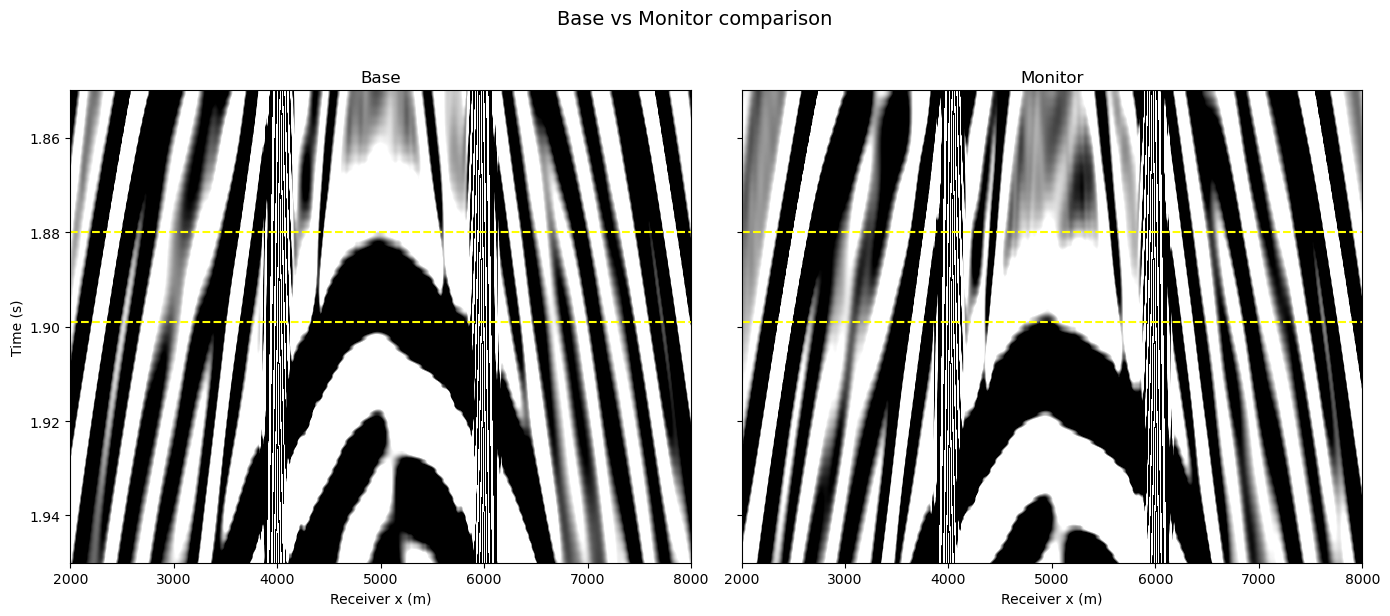

In [31]:
plot_base_monitor_side_by_side(
    g_base=gP_base,
    g_mon=gP_mon,        
    t=t,
    x_rec=x_rec,
    t_pick=[1.880, 1.899],
    y_lim=(1.85, 1.95),       
    clip=70,
)


Unfortunately, the bottom of layer 4 can not be distinguished clear enough to say something about the two-way travel time difference due to the velocity change. Therefore we are using a reflection below this layer. As nothing else has changed, only the velocity in layer 4, the difference in two-way travel time observed in a reflection below layer 4 is still due to the velocity change in layer 4.  

A shift in two way travel time for the selected reflection, can be seen in the difference between the two yellow lines in the plots. Events in the monitor survey arrive later compared to the base survey, which means the velocity decreases. These lines are indicated to be at t = 1.880 s and t = 1.899 s. The difference between the two is 0.019 seconds. This difference was determined visually, and there is thus a margin for error; especially with a difference as small as this.

The difference in velocity can be calculated through: 

$$\Delta v = 2s / \Delta t$$

Where, s is the thickness of the layer (layer 4 has size 2153 - 1893 = 260 m). This gives a total $$\Delta v = 2 * 260 / 0.19 = 2737 m/s$$  

## S-waves

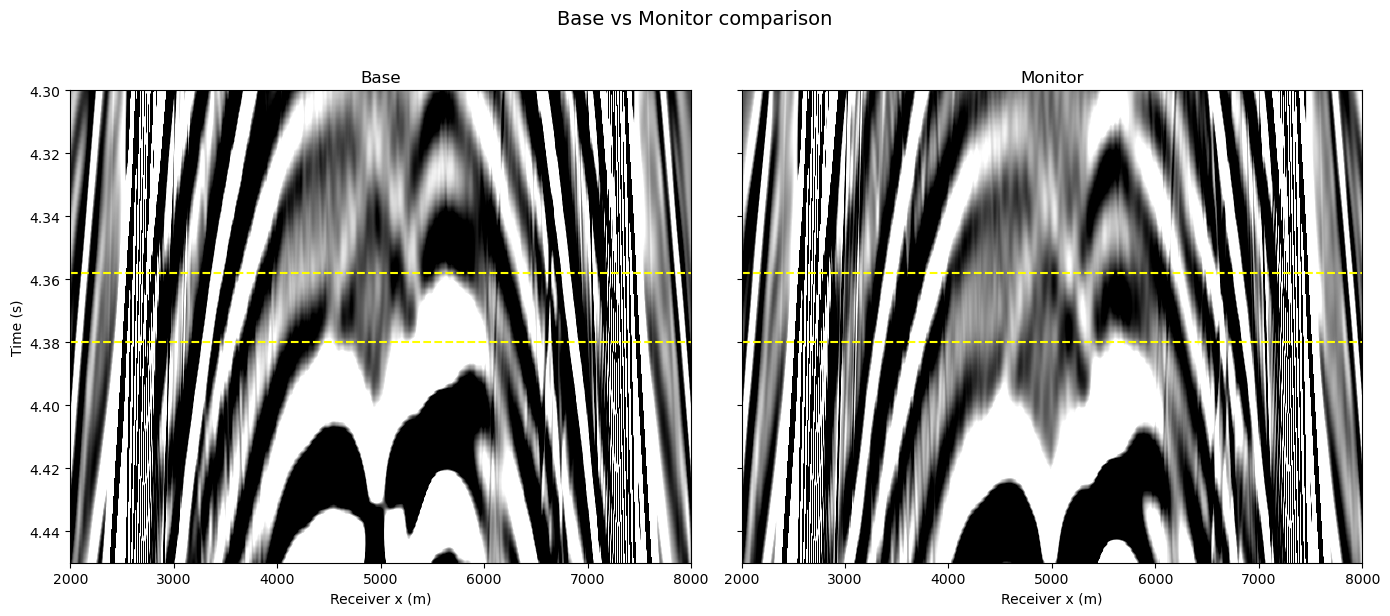

In [32]:
plot_base_monitor_side_by_side(
    g_base=gS_base,
    g_mon=gS_mon,        
    t=t,
    x_rec=x_rec,
    t_pick=[4.358, 4.38],
    y_lim=(4.3, 4.45),       
    clip=80,
)

As for the S-waves, a clear distinguishable reflection difference was found at a two way travel time of approximately 4.35 s. 

A shift in two way travel time for the selected reflection, can be seen in the difference between the two yellow lines in the plots. These lines are indicated to be at t = 4.358 s and t = 4.38 s.  Events in the monitor survey arrive later compared to the base survey, which means the velocity decreases. The difference between the two is 0.022 seconds. This difference was determined visually, and there is thus a margin for error; especially with a difference as small as this.

The difference in velcoity can be calculated through: 

$$\Delta v = 2s / \Delta t$$

In which s is the size of the layer (layer 4 has size 2153 - 1893 = 260 m). This gives a total $$\Delta v = 2 * 260 / 0.22 = 2363 m/s$$  

## Velocity difference plots

The velocity decreases in the 4th layer, as the monitor plots show that certain reflections arrive later. The velocity change between base and monitor is computed and visualised with the code and plots below.

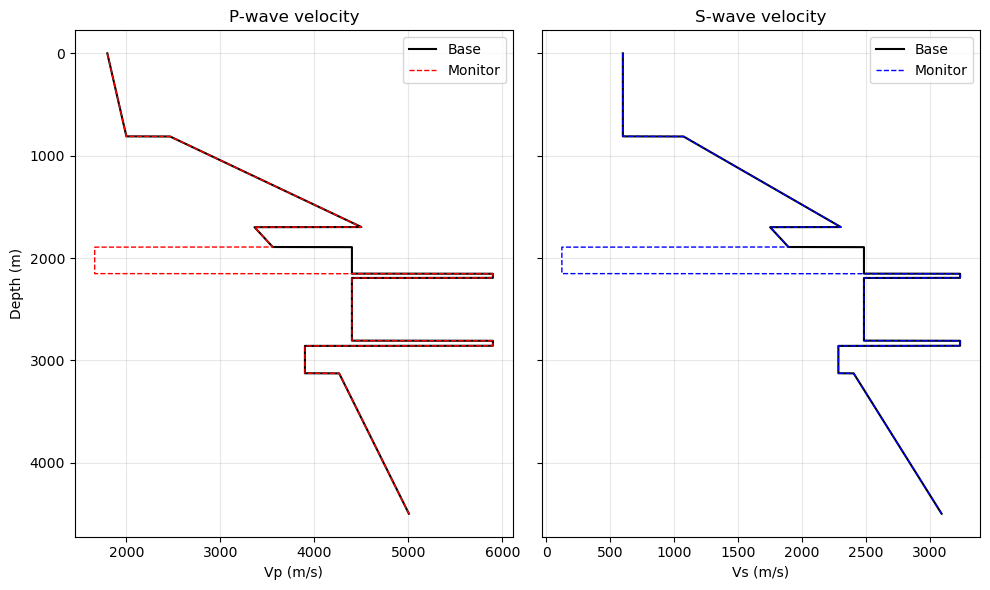

In [33]:
delta_vP_layer4 = 2737
delta_vS_layer4 = 2363

vp_log_monitor = vp_log.copy()
vp_log_monitor[idxP[2]:idxP[3]] -= delta_vP_layer4

vs_log_monitor = vs_log.copy()
vs_log_monitor[idxS[2]:idxS[3]] -= delta_vS_layer4

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

axes[0].plot(vp_log, z, label="Base", color="black")
axes[0].plot(vp_log_monitor, z, label="Monitor", color="red", linestyle="--", lw=1)
axes[0].set_xlabel("Vp (m/s)")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("P-wave velocity")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(vs_log, z, label="Base", color="black")
axes[1].plot(vs_log_monitor, z, label="Monitor", color="blue", linestyle="--", lw=1)
axes[1].invert_yaxis()
axes[1].set_xlabel("Vs (m/s)")
axes[1].set_title("S-wave velocity")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In these plots, a clear reduction in velocity is visible due to the change in layer 4.

# Task 6

The random source location at the borehole location is at: x = 5000 and at depth of reservoir z=2808 m. This is a logical location, because likelihood of the event hapening at that location is high. We assume straight horizontal lines as soil profile boundaries, although this is not the reality, this is done to simplify the problem. We will use a raytracing method to determine the difference in arrival time between the base and the monitoring set. To do this we will make use of Snellls Law to determine the angles of the rays. 

For this assignment, it was chosen to work with P-waves instead of S-waves. The choice was made based on the previous exercise where the velocity of the s-waves almost reaches zero, while the p-wave does not. The relative change in velocity is thus better for p-waves.

First, the velocity profile of the base-survey is known, with this the trajectory to the top can be computed. To do so, an array of initial angles from the earthquake’s location is used. At each layer crossing, this will result in a new theta for the trajectory in that new layer. This can be computed using Snell’s Law, which is:

$$
v_1 \cdot sin(\theta_1) = v_2 \cdot sin(\theta_2) \\
$$

where

\begin{aligned}
v_1      &:\ \text{velocity at the bottom of the layer} \\
\theta_1&:\ \text{incoming angle of the wave relative to the horizontal layer} \\
v_2      &:\ \text{velocity at the top of the layer} \\
\theta_2&:\ \text{outgoing angle of the wave relative to the horizontal layer}
\end{aligned}


This formula describes how waves are bent when going from one medium to another, in this case from one soil layer to another; which is known as refraction. This is done per depth discretization (dz) as the velocity profile also changes in between layer edges (in the layer itself). 
Doing this for the base survey results in an array of end locations, x-coordinates, at the top surface layer. The initial theta of a trajectory is then coupled to an end location.

Second, the same process is set up for the monitor-survey velocities. The difference is that the desired end locations are already known, only the new corresponding initial thetas coupled to the known end locations need to be determined. To do so, another array of thetas is used. Due to the change in the layer, the velocity profile is different, and the refraction profile will also be different. A theta that was determined in the first process will now have a different point if finishing at the top layer. This also means that at the same end coordinate, a different initial theta is now coupled. This results in a combination of only two paths that have the same begin and end point, but with different initial angles and a different length; which results in different travel times. 

The new trajectory is now known, and the length of both trajectories is calculated. The difference in length gives the difference in arrival time by use of the following formula:
$$

s = v \cdot t \quad \Rightarrow \quad t = \frac{s}{v}

$$

Per depth sampling, or dz, the time is calculated and the difference in arrival time is calculated.

In [34]:
def arrival_times_surface_receivers(theta0, v, z_inc, depths):
    
    "theta0 = initial angle from incident in degrees"
    "v = velocity profile as a function of depth"
    "z_inc = depth of incident"
    "depths = list of depths at which velocity changes significantly"
    
    dz = 1.25 # depth sampling
    v = v[0:int(z_inc/dz)]

    z = np.arange(-len(v)*dz, 0, dz)
    t_total = np.zeros(len(theta0))
    x_final = np.zeros(len(theta0))
    x_paths = {}
    thetas = {}
    
    
    plt.Figure(figsize=(10,6))

    for i in range(len(theta0)):
        theta = [theta0[i] * (np.pi/180)]
        x_path = [0]
        t_path = []
        for j in range(len(z) - 1):
            theta_j = theta[j]
            v_j = v[-1 - j]
            v_j1 = v[-2 - j]
            theta_j1 = np.arcsin((v_j * np.sin(theta_j)) / v_j1)
            theta.append(theta_j1)
            x_path.append(x_path[j] + (dz * np.tan(theta_j)))
            s = np.sqrt((dz**2) + ((x_path[j+1] - x_path[j])**2))
            t_path.append(s / (v_j))
            
        plt.plot(x_path, z, label=f"Incident angle: {theta[i]*(180/np.pi):.02f} degrees")
        plt.scatter([x_path[-1]], [z[-1]], color='g', marker='v')   
        
        t_total[i] = np.sum(t_path)
        x_final[i] = x_path[-1]
        x_paths[i] = x_path  
        thetas[i] = theta
        print(f"Total travel time for incident angle {theta0[i]:.06f} degrees: {t_total[i]:.06f} s, horizontal distance: {x_path[-1]:.06f} m")
    
    
    plt.scatter([0], [z[0]], color='b', marker='o', label='Source')
    plt.axhline(y=0, color='k', lw=1.2)
    for h in depths[0:6]:
        plt.axhline(y=-h, color='r', linestyle='--', lw=0.8)
        #plt.axhline(y=-h, color='r', linestyle='--', lw=0.8, label=f"Predicted reflector at ~{int(h)} m")
    plt.grid()
    plt.xlabel("x (m)")
    plt.ylabel("Depth (m)")
    plt.title("Ray paths for surface receivers at different incident angles")
    plt.legend(
        loc="lower right",
        fontsize=9,
        framealpha=0.9
    )
    plt.tight_layout()
    plt.show()
    
    return t_total, x_final, x_paths, thetas
       
        
        

Total travel time for incident angle 5.000000 degrees: 0.963372 s, horizontal distance: 369.438953 m
Total travel time for incident angle 10.000000 degrees: 1.003288 s, horizontal distance: 766.563884 m
Total travel time for incident angle 15.000000 degrees: 1.087712 s, horizontal distance: 1238.690357 m
Total travel time for incident angle 20.000000 degrees: 1.284952 s, horizontal distance: 1933.710093 m


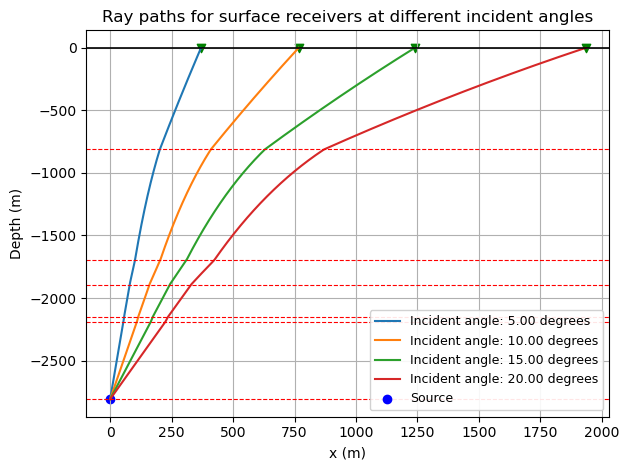

Total travel time for incident angle 4.535463 degrees: 1.061805 s, horizontal distance: 369.438964 m
Total travel time for incident angle 9.067850 degrees: 1.105423 s, horizontal distance: 766.563896 m
Total travel time for incident angle 13.606698 degrees: 1.196658 s, horizontal distance: 1238.690373 m
Total travel time for incident angle 18.211815 degrees: 1.406196 s, horizontal distance: 1933.710211 m


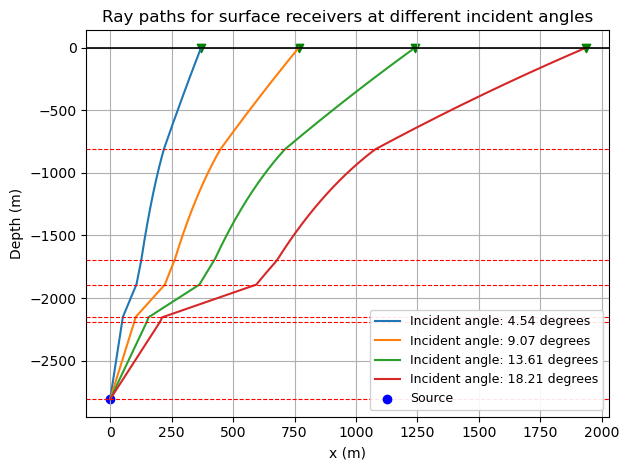

In [35]:
arr_times_base, x_final_base, x_path_base, thetas_base  = arrival_times_surface_receivers([5, 10, 15, 20], vp_log, 2808, depthsP)
arr_times_mon, x_final_mon, x_path_mon, thetas_mon = arrival_times_surface_receivers([4.535463, 9.06785, 13.6066977, 18.2118147], vp_log_monitor, 2808, depthsP)

In the first plot, the paths are shown for the base-survey velocity for a range of arbitrary initial theta's. In the second plot, the paths are shown for the monitor-survey velocity for a range of arbitrary initial theta's.

As can be seen, choosing a larger initial angle increases the total travel time, which is to be expected. It is also evident that the base-survey travels faster than the monitor-survey from the plots and given travel times. This makes sense as the monitor-survey has a lower velocity in layer 4. 

Below is the code used to plot the change of arrival time for different stations. These are the 'stations' observed in the plot above, following from raytracing for a range of arbitrary initial theta's.

Text(0, 0.5, 'Arrival time difference Δt (s)')

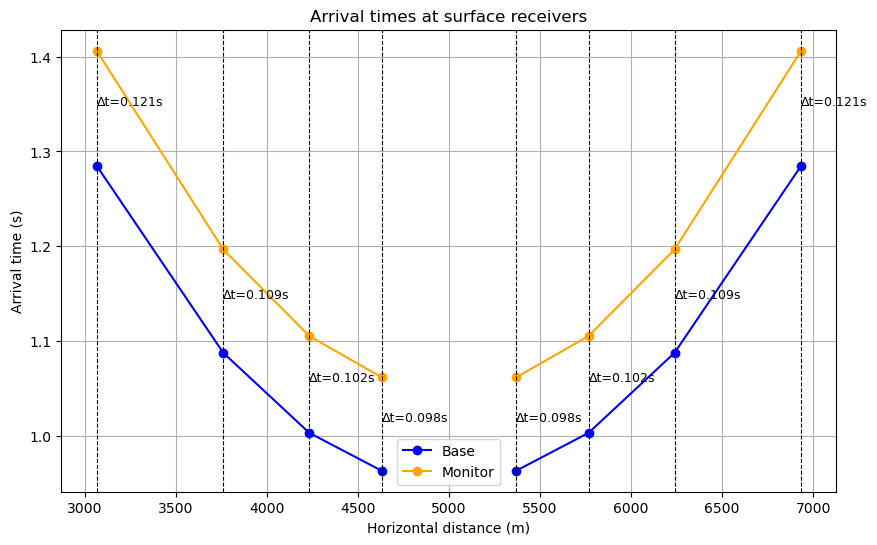

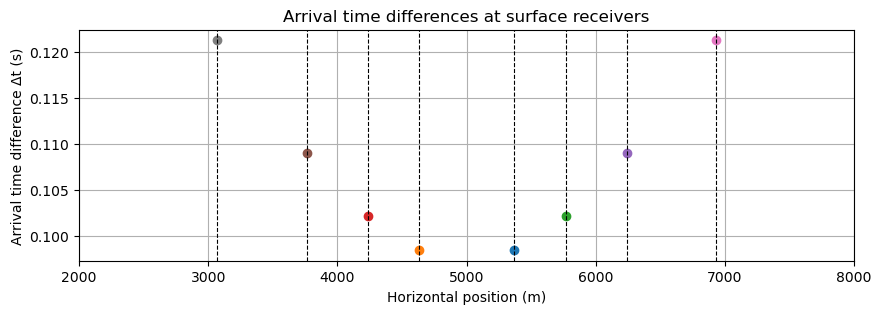

In [36]:
#diff_arrival_times = total_times_monitor - total_times_base
plt.figure(figsize=(10,6))
plt.plot(5000 + x_final_base, arr_times_base, color='b', label="Base", marker='o')
plt.plot(5000 + x_final_mon, arr_times_mon, color='orange', label="Monitor", marker='o')
plt.plot(5000 - x_final_base, arr_times_base, color='b', marker='o')
plt.plot(5000 - x_final_mon, arr_times_mon, color='orange', marker='o')
for i in range(len(x_final_base)):
    plt.axvline(5000 + x_final_base[i], color='k', lw=0.8, linestyle='--')
    plt.axvline(5000 - x_final_base[i], color='k', lw=0.8, linestyle='--')

    diff_arrival_times = arr_times_mon[i] - arr_times_base[i]
    plt.text(
        5000 + x_final_base[i], 
        (arr_times_base[i] + arr_times_mon[i])/2,
        f"Δt={diff_arrival_times:.3f}s",
        color='black',
        fontsize=9,
        va='bottom',
        ha='left'
    )
    plt.text(
        5000 - x_final_base[i], 
        (arr_times_base[i] + arr_times_mon[i])/2,
        f"Δt={diff_arrival_times:.3f}s",
        color='black',
        fontsize=9,
        va='bottom',
        ha='left'
    )
plt.title("Arrival times at surface receivers")
plt.legend()
plt.grid()
plt.xlabel("Horizontal distance (m)")
plt.ylabel("Arrival time (s)")

plt.figure(figsize=(10,3))
plt.xlim(2000, 8000)
for i in range(len(x_final_base)):
    plt.axvline(x_final_base[i] + 5000, color='k', lw=0.8, linestyle='--', label=f"Receiver at x={x_final_base[i]:.2f} m")
    plt.axvline(5000 - x_final_base[i], color='k', lw=0.8, linestyle='--', label=f"Receiver at x={x_final_base[i]:.2f} m")

    diff_arrival_times = arr_times_mon[i] - arr_times_base[i]
    plt.scatter(x_final_base[i] + 5000, diff_arrival_times, label=f"Δt at x={x_final_base[i]:.2f} m: {diff_arrival_times:.3f}s")
    plt.scatter(5000 - x_final_base[i], diff_arrival_times, label=f"Δt at x={x_final_base[i]:.2f} m: {diff_arrival_times:.3f}s")

plt.grid()
plt.title("Arrival time differences at surface receivers")
plt.xlabel("Horizontal position (m)")
plt.ylabel("Arrival time difference Δt (s)")

In this plot, the difference in arrival time is plotted against the horizontal distance. By subtracting the arrival times at the same horizontal distance, the difference in arrival time is calculated and shown in the graph.
In the top graph, every dot represents the arrival of a wave at the top surface layer. This allows for the ability to compare different arrival times for the ray paths. The difference in arrival times is plotted in the bottom graph, where again, each dot represents one ray.

The code below is used to showcase the raypath arriving at the same station, with and without a velocity change in layer 4.

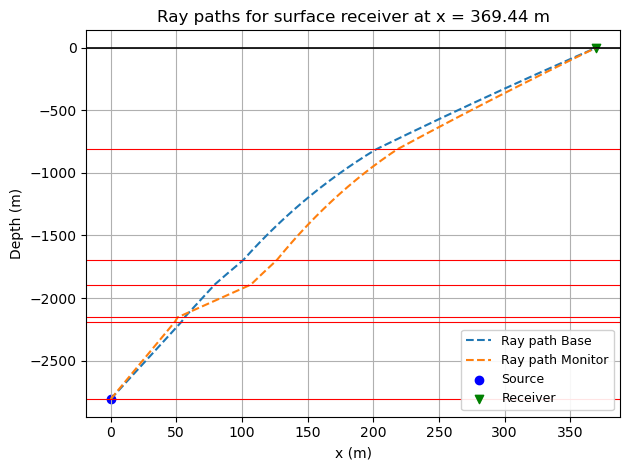

In [37]:
z = np.arange(-len(x_path_base[0])*1.25, 0, 1.25)

plt.plot(x_path_base[0], z, linestyle='--', alpha=1, label="Ray path Base")
plt.plot(x_path_mon[0], z, linestyle='--', alpha=1, label="Ray path Monitor")
plt.scatter([0], [z[0]], color='b', marker='o', label='Source')
plt.scatter([x_final_base[0]], [z[-1]], color='g', marker='v', label='Receiver')   
plt.axhline(y=0, color='k', lw=1.2)
for h in depthsP[0:6]:
    plt.axhline(y=-h, color='r', lw=0.8)
plt.grid()
plt.xlabel("x (m)")
plt.ylabel("Depth (m)")
plt.title(f"Ray paths for surface receiver at x = {x_final_base[0]:.2f} m")
plt.legend(
    loc="lower right",
    fontsize=9,
    framealpha=0.9
)
plt.tight_layout()
plt.show()

In this final plot, the two trajectories are plotted alongside each other for the same begin and end point. The blue dashed line represents the base-survey velocities and the orange dashed line the monitor-survey velocities.

# Task 7

This task consists out of two steps. First the code of task 6 has been used to determine the receiver location using the earthquake location and the base velocity profile as the starting point. This has already be done in task 6. At the source, an initial angle of 5 degrees has been used. It should be noted that a larger initial angle will result in using a receiver further away from the source. This will also result in a larger effect on the earthquake guess with the monitor velocity profile. Thus, using a receiver closer to the source will automatically result in a better identification of the source using the monitoring velocity profile. For the second part the function from task 6 has been slightly changed to flip the direction of the raytracing. As input angle the final angle computed for the upwards raytracing has been used. 

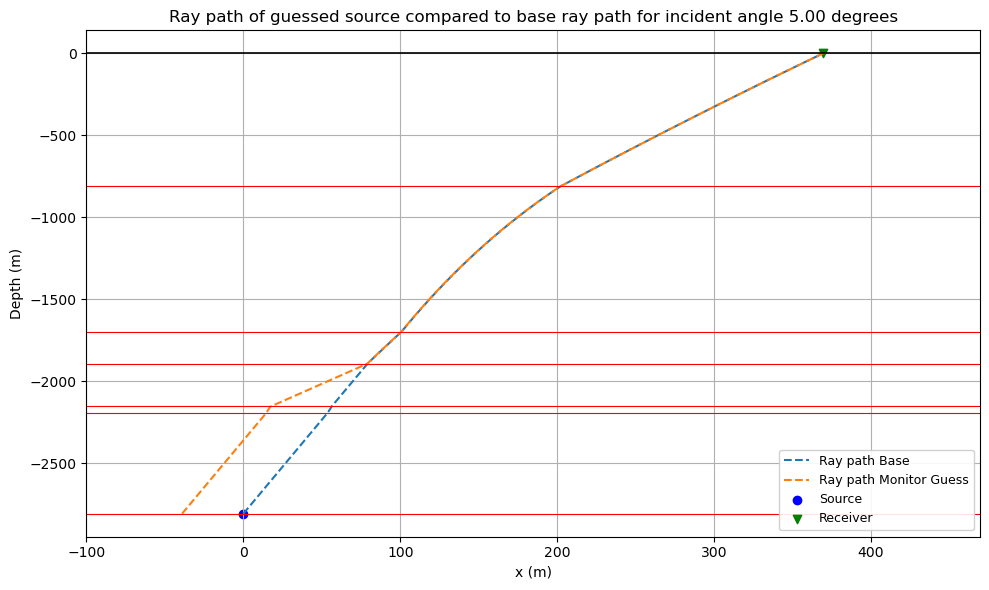

In [38]:
def arrival_times_receiver_to_source(theta0, v, z_inc, depths):
    
    "theta0 = initial angle from incident in degrees"
    "v = velocity profile as a function of depth"
    "z_inc = depth of incident"
    "depths = list of depths at which velocity changes significantly"
    
    dz = 1.25 # depth sampling
    v = v[0:int(z_inc/dz)]

    z = -1 * np.arange(0, len(v)*dz, dz)
    t_total = np.zeros(len(theta0))
    x_final = np.zeros(len(theta0))
    x_paths = {}
    thetas = {}
    
    
    plt.Figure(figsize=(10,6))

    for i in range(len(theta0)):
        theta = [theta0[i] * (np.pi/180)]
        x_path = [0]
        t_path = []
        for j in range(len(z) - 1):
            theta_j = theta[j]
            v_j = v[j]
            v_j1 = v[j+1]
            theta_j1 = np.arcsin((v_j * np.sin(theta_j)) / v_j1)
            theta.append(theta_j1)
            x_path.append(x_path[j] + (dz * np.tan(theta_j)))
            s = np.sqrt((dz**2) + ((x_path[j+1] - x_path[j])**2))
            t_path.append(s / (v_j))
        
        t_total[i] = np.sum(t_path)
        x_final[i] = x_path[-1]
        x_paths[i] = x_path  
        thetas[i] = theta
    return t_total, x_final, x_paths, thetas

theta_start = thetas_base[0][-1] * (180/np.pi)

arr_times_guess, x_final_guess, x_path_guess, thetas_guess = arrival_times_receiver_to_source([-theta_start], vp_log_monitor, 2808, depthsP)
x_path_guess_flipped = x_path_guess[0][::-1] + x_final_base[0]

plt.figure(figsize=(10,6))
plt.plot(x_path_base[0], z, linestyle='--', alpha=1, label="Ray path Base")
plt.plot( x_path_guess_flipped, z, linestyle='--', alpha=1, label="Ray path Monitor Guess")
plt.scatter([0], [z[0]], color='b', marker='o', label='Source')
plt.scatter([x_final_base[0]], [z[-1]], color='g', marker='v', label='Receiver')   
plt.axhline(y=0, color='k', lw=1.2)
for h in depthsP[0:6]:
    plt.axhline(y=-h, color='r', lw=0.8)
plt.grid()
plt.xlabel("x (m)")
plt.xlim(-100, x_final_base[0]+100)
plt.ylabel("Depth (m)")
plt.title(f"Ray path of guessed source compared to base ray path for incident angle {thetas_base[0][0] * (180/np.pi):.02f} degrees")
plt.legend(
    loc="lower right",
    fontsize=9,
    framealpha=0.9
)
plt.tight_layout()
plt.show()



From the plot it can be seen clearly seen that the path of the monitoring ray deviates from the base ray in the layer where the velocity change has occurred. Below the absolute difference and the difference in percentage between the source and the guess made with the monitoring survey have been displayed. The percentage is of importance because of the phenomenon described earlier that the receiver location has influence on the guess of the source. The percentage is computed as follows:


$$
percentage = \frac{Error}{\text{Distance source to receiver}}\cdot 100\% 
$$


In [39]:
print(f"The location would be {((-x_final_guess[0] - x_final_base[0]) / x_final_base[0])*100:.2f} % further away from the source.")
print(f"The absolute difference of earthquake location is {(-x_final_guess[0] - x_final_base[0]):.2f} m.")

The location would be 10.57 % further away from the source.
The absolute difference of earthquake location is 39.03 m.


Below the offset difference between different incident angles (corresponding to a difference in receiver distance) is computed. This is done to see the difference in absolute error but also the percentage relative to the distance to the receiver, according to the formula discribed above.


Total travel time for incident angle 0.010000 degrees: 0.951344 s, horizontal distance: 0.730579 m
Total travel time for incident angle 0.100000 degrees: 0.951348 s, horizontal distance: 7.305826 m
Total travel time for incident angle 1.000000 degrees: 0.951814 s, horizontal distance: 73.090352 m


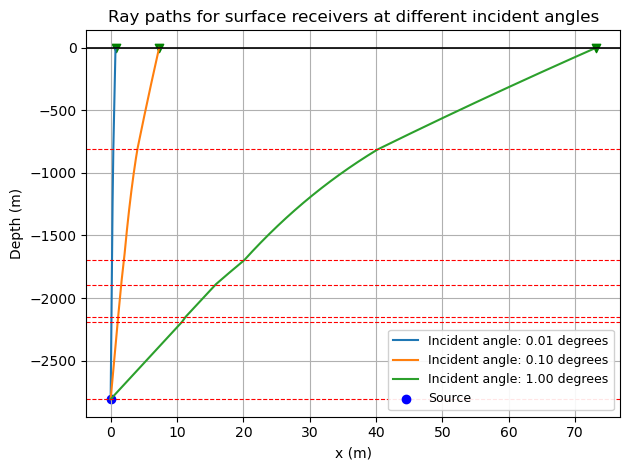

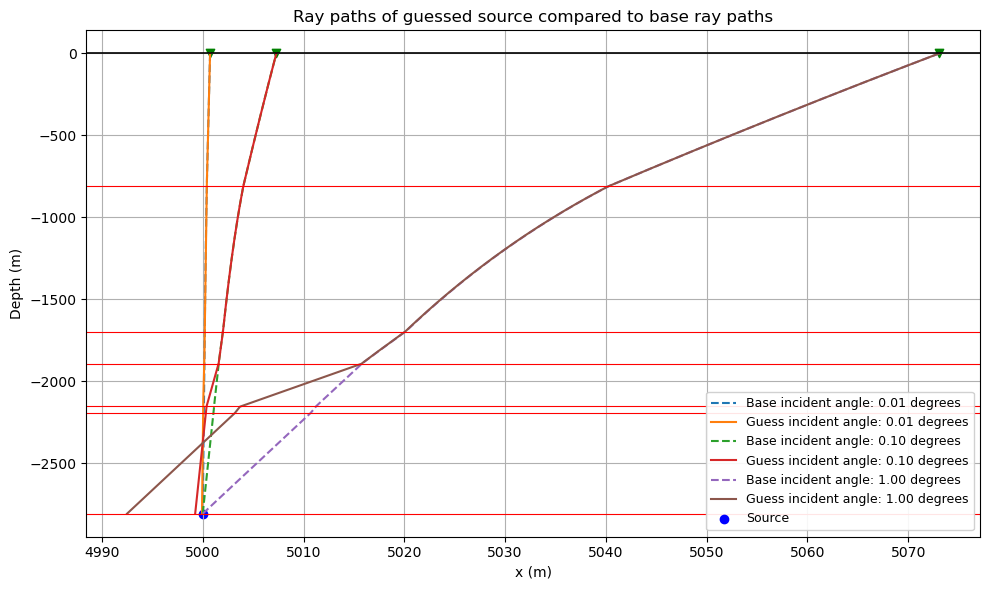

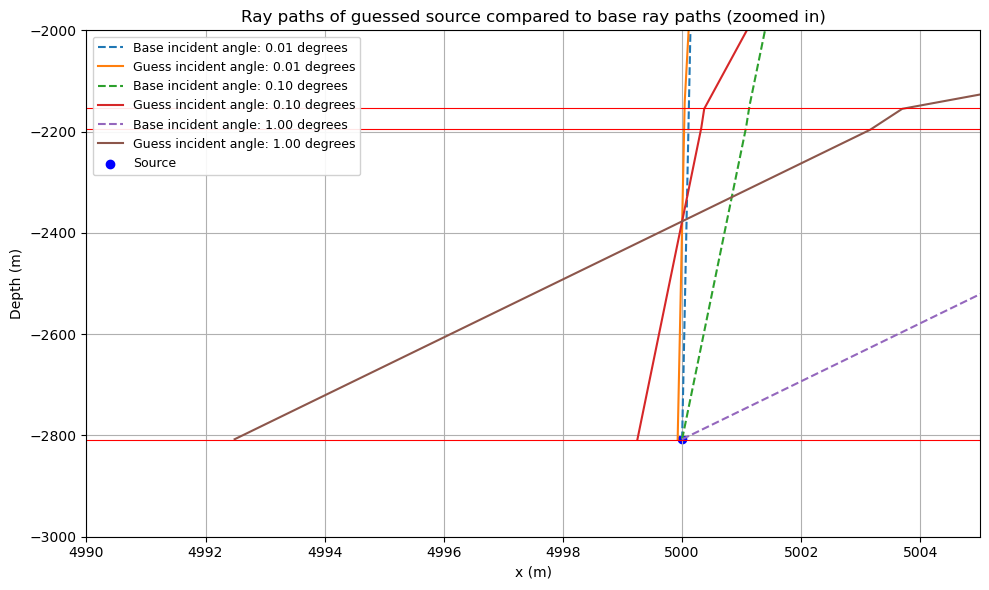

The location for incident angle 0.01 would be 10.27 % further away from the source.
The absolute difference of earthquake location for incident angle 0.01 is 0.08 m.
The location for incident angle 0.10 would be 10.27 % further away from the source.
The absolute difference of earthquake location for incident angle 0.10 is 0.75 m.
The location for incident angle 1.00 would be 10.28 % further away from the source.
The absolute difference of earthquake location for incident angle 1.00 is 7.51 m.


In [40]:
arr_times_base2, x_final_base2, x_path_base2, thetas_base2  = arrival_times_surface_receivers([0.01, 0.1, 1], vp_log, 2808, depthsP)


theta_start2 = []
for i in range(len(x_final_base2)):
    theta_start2.append(thetas_base2[i][-1] * (-180/np.pi))
    
arr_times_guess2, x_final_guess2, x_path_guess2, thetas_guess2 = arrival_times_receiver_to_source(theta_start2, vp_log_monitor, 2808, depthsP)

plt.figure(figsize=(10,6))
for i in range(len(x_final_base2)):
    x_path_shifted = np.asarray(x_path_base2[i]) + 5000
    plt.plot(x_path_shifted, z, linestyle='--', alpha=1, label=f"Base incident angle: {thetas_base2[i][0] * (180/np.pi):.02f} degrees")

    x_path_guess_flipped2 = np.asarray(x_path_guess2[i][::-1]) + x_final_base2[i] + 5000
    plt.plot(x_path_guess_flipped2, z, linestyle='-', alpha=1, label=f"Guess incident angle: {thetas_base2[i][0] * (180/np.pi):.02f} degrees")

    plt.scatter([x_final_base2[i] + 5000], [z[-1]], color='g', marker='v')

plt.scatter([5000], [z[0]], color='b', marker='o', label='Source')
plt.axhline(y=0, color='k', lw=1.2)
for h in depthsP[0:6]:
    plt.axhline(y=-h, color='r', lw=0.8)
plt.grid()
plt.xlabel("x (m)")
plt.ylabel("Depth (m)")
plt.title(f"Ray paths of guessed source compared to base ray paths")
plt.legend(
    loc="lower right",
    fontsize=9,
    framealpha=0.9
)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
for i in range(len(x_final_base2)):
    x_path_shifted = np.asarray(x_path_base2[i]) + 5000
    plt.plot(x_path_shifted, z, linestyle='--', alpha=1, label=f"Base incident angle: {thetas_base2[i][0] * (180/np.pi):.02f} degrees")

    x_path_guess_flipped2 = np.asarray(x_path_guess2[i][::-1]) + x_final_base2[i] + 5000
    plt.plot(x_path_guess_flipped2, z, linestyle='-', alpha=1, label=f"Guess incident angle: {thetas_base2[i][0] * (180/np.pi):.02f} degrees")

plt.scatter([5000], [z[0]], color='b', marker='o', label='Source')
plt.axhline(y=0, color='k', lw=1.2)
for h in depthsP[0:6]:
    plt.axhline(y=-h, color='r', lw=0.8)
plt.grid()
plt.xlim(4990, 5005)
plt.ylim(-3000, -2000)
plt.xlabel("x (m)")
plt.ylabel("Depth (m)")
plt.title(f"Ray paths of guessed source compared to base ray paths (zoomed in)")
plt.legend(
    loc="upper left",
    fontsize=9,
    framealpha=0.9
)
plt.tight_layout()
plt.show()

for i in range(len(x_final_base2)):    
    print(f"The location for incident angle {thetas_base2[i][0] * (180/np.pi):.02f} would be {((-x_final_guess2[i] - x_final_base2[i]) / x_final_base2[i])*100:.2f} % further away from the source.")
    print(f"The absolute difference of earthquake location for incident angle {thetas_base2[i][0] * (180/np.pi):.02f} is {(-x_final_guess2[i] - x_final_base2[i]):.2f} m.")

Based on the print statements and plot it can be concluded that using receivers further away from the source will results in a larger absolute error. The computed percentages also increase but by marginal amounts compared to the change in absolute distance. 

# Task 8

For task 8, different scenarios have been set up to show the effects of certain changes in the ground profile. 3 types of changes have been performed:
1. Change the velocity with the same amount (-1500 m/s) in different layers.
2. Change the velocity with different amounts in one layer (layer 2)
3. Set velocity in layers 2 until 6 to a uniform value 

By setting up the different scenarios it is possible to show what the magnitude of effect is of a certain change on the guess of the location of the earthquake. In case the velocity is uncertain in a layer, it can be shown what kind of effect this can have on the guess of the earthquake location.

### Changing the velocity with the same amount (-1500 m/s) in different layers.

For the first set of scenarios, the velocity has been changed with the same amount in different layers. 1500 m/s has been subtracted from the velocities in layers 2, 3, 4, 6 independently. Layer 5 has been excluded from the plot because the layer is relatively thin, which has minimal effect on the prediction of the earthquake location. This has resulted in the first conclusion: the smaller the layer the less effect it has on the final guess. This makes sense as the angle change of the ray, caused by the velocity change, only contributes to the offset of the guess in its own layer. The value of the change in velocity has been used, because it is substantial enough to clearly show the changes. A negative change has been used because this has more effect on the final guess, from which it can be concluded that uncertainties in the negative (change) direction have more effect on the uncertainties of the final guess.

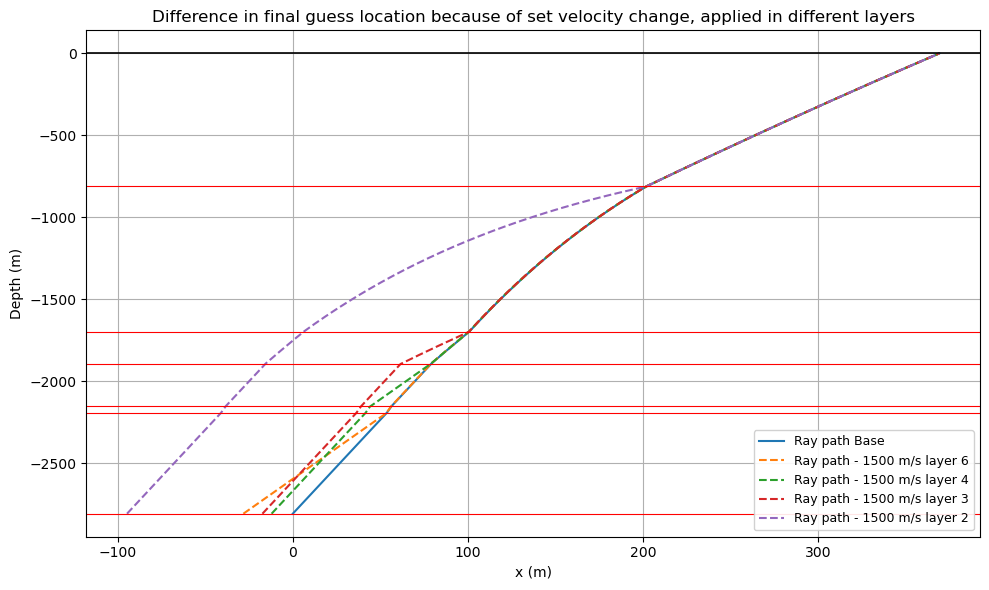

In [48]:
#change vel in layer 4
vp_senario1 = vp_log.copy()
vp_senario1[idxP[2]:idxP[3]] -= 1500

#change vel in layer 3
vp_senario2 = vp_log.copy()
vp_senario2[idxP[1]:idxP[2]] -= 1500

#change vel in layer 2
vp_senario3 = vp_log.copy()
vp_senario3[idxP[0]:idxP[1]] -= 1500

#change vel in layer 6
vp_senario4 = vp_log.copy()
vp_senario4[idxP[4]:idxP[5]] -= 1500

arr_times_sen1, x_final_sen1, x_path_sen1, thetas_sen1 = arrival_times_receiver_to_source([-theta_start], vp_senario1, 2808, depthsP)
arr_times_sen2, x_final_sen2, x_path_sen2, thetas_sen2 = arrival_times_receiver_to_source([-theta_start], vp_senario2, 2808, depthsP)
arr_times_sen3, x_final_sen3, x_path_sen3, thetas_sen3 = arrival_times_receiver_to_source([-theta_start], vp_senario3, 2808, depthsP)
arr_times_sen4, x_final_sen4, x_path_sen4, thetas_sen4 = arrival_times_receiver_to_source([-theta_start], vp_senario4, 2808, depthsP)



plt.figure(figsize=(10,6))

plt.plot(x_path_base[0], z, linestyle='-', alpha=1, label="Ray path Base")
plt.plot(x_path_sen4[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path - 1500 m/s layer 6")
plt.plot(x_path_sen1[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path - 1500 m/s layer 4")
plt.plot(x_path_sen2[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path - 1500 m/s layer 3")
plt.plot(x_path_sen3[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path - 1500 m/s layer 2")




plt.axhline(y=0, color='k', lw=1.2)
for h in depthsP[0:6]:
    plt.axhline(y=-h, color='r', lw=0.8)
    
plt.grid()
plt.xlabel("x (m)")
plt.ylabel("Depth (m)")
plt.title(f"Difference in final guess location because of set velocity change, applied in different layers")
plt.legend(
    loc="lower right",
    fontsize=9,
    framealpha=0.9
)
plt.tight_layout()
plt.show()

From the plot it can be deducted that changes in velocities usually have more effect when they occur in larger layers. This makes sense as the change in velocity has had more 'time' to influence the final guess, due to a thicker layer thus longer time spent in that layer. Uncertainty in larger layers thus has more effect of the uncertainty of the final guess. Another conclusion that can be drawn is that the relative change is of importance. This is concluded from the fact that change in the thinner layer 3 has more effect on the final guess, than the thicker layer 4. By changing the velocities, the percentage change of layer 3 was larger. Meaning that when looking at velocity uncertainties, the percentage of the uncertainty is of importance when comparing it between layers.

### Changing the velocity with different amounts in one layer (layer 2)

For scenario set two the velocity of only one layer (layer 2) has been changed.

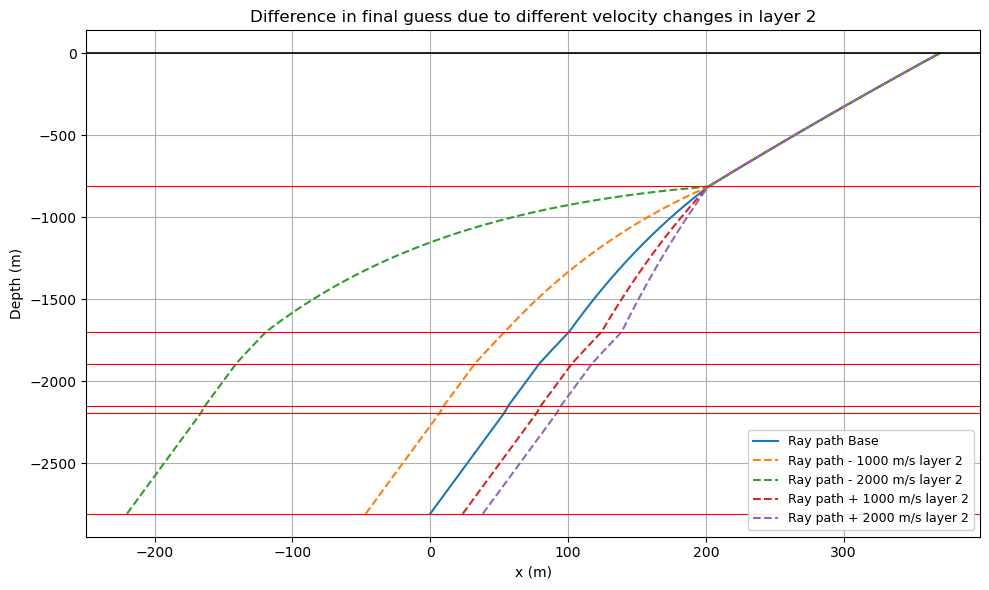

In [41]:
vp_senario1 = vp_log.copy()
vp_senario1[idxP[0]:idxP[1]] -= 1000

vp_senario2 = vp_log.copy()
vp_senario2[idxP[0]:idxP[1]] -= 2000

vp_senario3 = vp_log.copy()
vp_senario3[idxP[0]:idxP[1]] += 1000

vp_senario4 = vp_log.copy()
vp_senario4[idxP[0]:idxP[1]] += 2000

arr_times_sen1, x_final_sen1, x_path_sen1, thetas_sen1 = arrival_times_receiver_to_source([-theta_start], vp_senario1, 2808, depthsP)
arr_times_sen2, x_final_sen2, x_path_sen2, thetas_sen2 = arrival_times_receiver_to_source([-theta_start], vp_senario2, 2808, depthsP)
arr_times_sen3, x_final_sen3, x_path_sen3, thetas_sen3 = arrival_times_receiver_to_source([-theta_start], vp_senario3, 2808, depthsP)
arr_times_sen4, x_final_sen4, x_path_sen4, thetas_sen4 = arrival_times_receiver_to_source([-theta_start], vp_senario4, 2808, depthsP)

plt.figure(figsize=(10,6))


plt.plot(x_path_base[0], z, linestyle='-', alpha=1, label="Ray path Base")
plt.plot(x_path_sen1[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path - 1000 m/s layer 2")
plt.plot(x_path_sen2[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path - 2000 m/s layer 2")
plt.plot(x_path_sen3[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path + 1000 m/s layer 2")
plt.plot(x_path_sen4[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path + 2000 m/s layer 2")



plt.axhline(y=0, color='k', lw=1.2)
for h in depthsP[0:6]:
    plt.axhline(y=-h, color='r', lw=0.8)
    
plt.grid()
plt.xlabel("x (m)")
plt.ylabel("Depth (m)")
plt.title(f"Difference in final guess due to different velocity changes in layer 2")
plt.legend(
    loc="lower right",
    fontsize=9,
    framealpha=0.9
)
plt.tight_layout()
plt.show()

From the plot it can be concluded that the magnitude of the change matters. A higher uncertainty in velocity results in a higher uncertainty in the final guess. It should be noted that this does not have a linear distribution, it looks more like an exponential effect on the final guess; where upping the negative change of the velocity has an exponentially increasing effect on the final guess, and thus its uncertainty.

### Set velocity in layers 2 until 6 to a uniform value

In the final set of scenarios the whole velocity profile of layers 2 until 6 has been set to one value, essentially creating one layer. This results in excluding any linear change of the velocity.

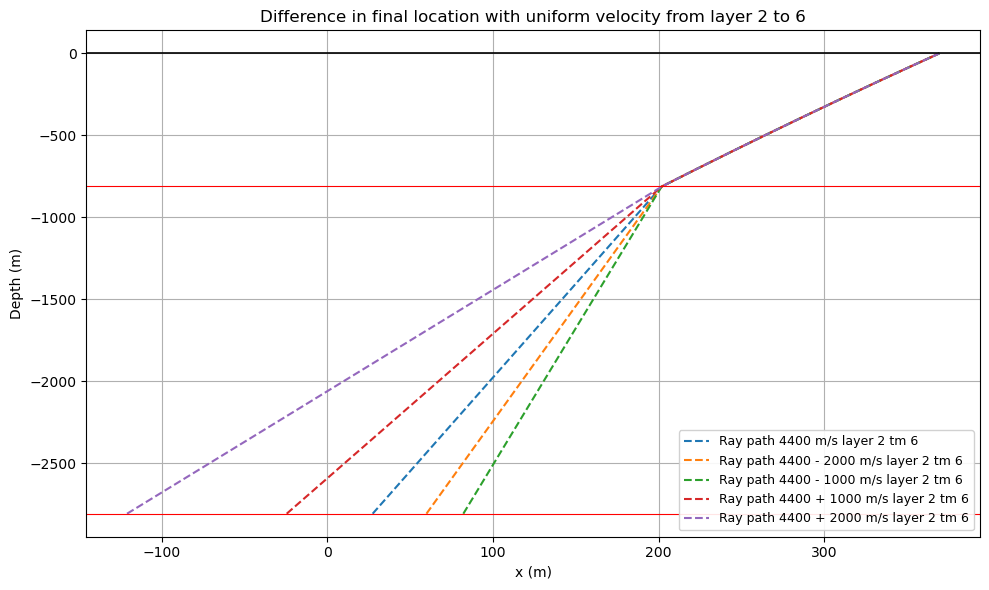

In [42]:
#set vel in layer 2 tm 6 t0 4400 m/s
vp_senario_set1 = vp_log.copy()
vp_senario_set1[idxP[0]:idxP[5]] = vp_log[idxP[2]]

#set vel in layer 2 tm 6 to 5400 m/s
vp_senario_set2 = vp_log.copy()
vp_senario_set2[idxP[0]:idxP[5]] = vp_log[idxP[2]] + 1000

#set vel in layer 2 tm 6 to 6400 m/s
vp_senario_set3 = vp_log.copy()
vp_senario_set3[idxP[0]:idxP[5]] = vp_log[idxP[2]] + 2000

#set vel in layer 2 tm 6 to 3400 m/s
vp_senario_set4 = vp_log.copy()
vp_senario_set4[idxP[0]:idxP[5]] = vp_log[idxP[2]] - 1000

#set vel in layer 2 tm 6 to 2400 m/s
vp_senario_set5 = vp_log.copy()
vp_senario_set5[idxP[0]:idxP[5]] = vp_log[idxP[2]] - 2000

arr_times_set1, x_final_set1, x_path_set1, thetas_set1 = arrival_times_receiver_to_source([-theta_start], vp_senario_set1, 2808, depthsP)
arr_times_set2, x_final_set2, x_path_set2, thetas_set2 = arrival_times_receiver_to_source([-theta_start], vp_senario_set2, 2808, depthsP)
arr_times_set3, x_final_set3, x_path_set3, thetas_set3 = arrival_times_receiver_to_source([-theta_start], vp_senario_set3, 2808, depthsP)
arr_times_set4, x_final_set4, x_path_set4, thetas_set4 = arrival_times_receiver_to_source([-theta_start], vp_senario_set4, 2808, depthsP)
arr_times_set5, x_final_set5, x_path_set5, thetas_set5 = arrival_times_receiver_to_source([-theta_start], vp_senario_set5, 2808, depthsP)


plt.figure(figsize=(10,6))


plt.plot(x_path_set1[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path 4400 m/s layer 2 tm 6")
plt.plot(x_path_set2[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path 4400 - 2000 m/s layer 2 tm 6")
plt.plot(x_path_set3[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path 4400 - 1000 m/s layer 2 tm 6")
plt.plot(x_path_set4[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path 4400 + 1000 m/s layer 2 tm 6")
plt.plot(x_path_set5[0][::-1] + x_final_base[0], z, linestyle='--', alpha=1, label="Ray path 4400 + 2000 m/s layer 2 tm 6")

plt.axhline(y=0, color='k', lw=1.2)
plt.axhline(y=-depthsP[0], color='r', lw=0.8)
plt.axhline(y=-depthsP[5], color='r', lw=0.8)
    
plt.grid()
plt.xlabel("x (m)")
plt.ylabel("Depth (m)")
plt.title(f"Difference in final location with uniform velocity from layer 2 to 6")
plt.legend(
    loc="lower right",
    fontsize=9,
    framealpha=0.9
)
plt.tight_layout()
plt.show()

Again, it can be concluded that negative change in velocity has more effect on the final guess of the earthquake location. Also showing the exponential change described before. Resulting in uncertainty of the velocity to lower values having more effect on the uncertainty of the final guess. Based on this, it can be concluded that this is governing. 

Important to note is that the closer a receiver is to the source, the more certain the prediction of the source location. This means that if the receiver is straight up from the source (smaller angle), the smaller the bandwidth in which your prediction of the source location will be.